In [1]:
import pickle
import pandas as pd
editors = ["pythia","pythia2","gptj"]
datasets = ["sst2","imdb","news"]
fine_tune = [True]
results = {}
for editor in editors:
    for ds in datasets:
        for ft in fine_tune:
            with open(f"camel/cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}_0_200.pcl","br") as f:
                df = pd.DataFrame(pickle.load(f))
                # df.to_csv(f"camel_csv/cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}.csv")
                results[f"cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}"] = df


fine_tune = [False]
for editor in editors:
    for ds in datasets:
        for ft in fine_tune:
            with open(f"camel/cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}_0_200_zero.pcl","br") as f:
                df = pd.DataFrame(pickle.load(f))
                # df.to_csv(f"camel_csv/cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}_zero.csv")
                results[f"cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}_zero"] = df

results2 = {}
fine_tune = [False]
for ds in datasets:
    for ft in fine_tune:
        with open(f"camel_mask2/{ds}_predictor_gemma-2b_ft_{ft}_0_200_zero.pcl","br") as f:
            m = pickle.load(f)
            m["sentence"] = m["sentence"][:200]
            df = pd.DataFrame(m)
            # # df.to_csv(f"camel_csv/cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}_zero.csv")
            results2[f"{ds}_predictor_gemma-2b_ft_{ft}_mask_zero"] = df


fine_tune = [True]
for ds in datasets:
    for ft in fine_tune:
        with open(f"camel_mask2/{ds}_predictor_gemma-2b_ft_{ft}_0_200.pcl","br") as f:
            m = pickle.load(f)
            m["sentence"] = m["sentence"][:200]
            df = pd.DataFrame(m)
            # # df.to_csv(f"camel_csv/cfg_{editor}_{ds}_predictor_gemma-2b_ft_{ft}_zero.csv")
            results2[f"{ds}_predictor_gemma-2b_ft_{ft}_mask"] = df


In [2]:
sst_original_sen = results['cfg_pythia_sst2_predictor_gemma-2b_ft_True'].sentence.values.tolist()
imdb_original_sen = results['cfg_pythia_imdb_predictor_gemma-2b_ft_True'].sentence.values.tolist()
news_original_sen = results['cfg_pythia_news_predictor_gemma-2b_ft_True'].sentence.values.tolist()

# FT

In [3]:
datasets = ["sst2","imdb","news"]
device = "cuda:1"
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
percentile99 = {}
for ds in datasets:
    nlls_org = []
    pred_model_id = f"predictor_gemma-2b_{ds}_merged"
    tokenizer  = AutoTokenizer.from_pretrained(pred_model_id)
    pred_model = AutoModelForCausalLM.from_pretrained(pred_model_id,device_map=device,
                        torch_dtype=torch.float16,trust_remote_code=True, attn_implementation="flash_attention_2")
    for i in tqdm(range(200)):

        if ds =="sst2":
            input_ids = tokenizer(sst_original_sen[i]
                                    + " In a sentiment classification task between positive and negative choices, the sentiment of this sentence is ",
                                        return_tensors="pt")["input_ids"].to(device)
        if ds =="imdb":
            input_ids = tokenizer(imdb_original_sen[i] + 
                                    " Based on this opinion, decide what the sentiment is, choose between positive and negative. Answer is ",
                                    return_tensors="pt")["input_ids"].to(device)
        if ds == "news":
            input_ids = tokenizer(news_original_sen[i] + 
                                    " You are classifying a news article, Choose one of the four categories, World, Business, Sport, and Tech. Answer is " ,
                                    return_tensors="pt")["input_ids"].to(device)   
        target_ids = input_ids.clone()
        # target_ids[:, :-trg_len] = -100
        
        with torch.no_grad():
            outputs = pred_model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls_org.append(neg_log_likelihood)

    lls = torch.stack(nlls_org).cpu().numpy()
    percentile99[ds] = np.percentile(lls,99)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 86.42it/s]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 67.97it/s]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 74.13it/s]


In [5]:
explanation_types = ["gradnorm1","gradnorm2","gradinp","erasure","integrated_grad",
                     "kernel_shap","random"]

In [6]:
datasets = ["sst2","imdb","news"]
device = "cuda:1"
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
percentages = [0.1,0.2,0.3,0.4,0.5]
lls_list = {}
for ds in datasets:
    pred_model_id = f"predictor_gemma-2b_{ds}_merged"
    tokenizer  = AutoTokenizer.from_pretrained(pred_model_id)
    pred_model = AutoModelForCausalLM.from_pretrained(pred_model_id,device_map=device,
                                    torch_dtype=torch.float16,trust_remote_code=True, attn_implementation="flash_attention_2")
    for editor in editors:
        eval_data = results[f'cfg_{editor}_{ds}_predictor_gemma-2b_ft_True']
        for exp in explanation_types: 
            for percent in percentages:
                nlls_org = []
                
                
                for i in tqdm(range(200)):

                    if ds =="sst2":
                        input_ids = tokenizer(eval_data[f"{exp}_cfg_{editor}_{percent}_response_predictor_gemma-2b_ft_True"][i]
                                                + " In a sentiment classification task between positive and negative choices, the sentiment of this sentence is ",
                                                    return_tensors="pt")["input_ids"].to(device)
                    if ds =="imdb":
                        input_ids = tokenizer(eval_data[f"{exp}_cfg_{editor}_{percent}_response_predictor_gemma-2b_ft_True"][i] + 
                                                " Based on this opinion, decide what the sentiment is, choose between positive and negative. Answer is ",
                                                return_tensors="pt")["input_ids"].to(device)
                    if ds == "news":
                        input_ids = tokenizer(eval_data[f"{exp}_cfg_{editor}_{percent}_response_predictor_gemma-2b_ft_True"][i] + 
                                                " You are classifying a news article, Choose one of the four categories, World, Business, Sport, and Tech. Answer is " ,
                                                return_tensors="pt")["input_ids"].to(device)   
                    target_ids = input_ids.clone()
                    # target_ids[:, :-trg_len] = -100
                    
                    with torch.no_grad():
                        outputs = pred_model(input_ids, labels=target_ids)
                        neg_log_likelihood = outputs.loss

                    nlls_org.append(neg_log_likelihood)
                    lls = torch.stack(nlls_org).cpu().numpy()
                lls_list[f"{ds}-{editor}-{exp}-{percent}"] = lls
                print(lls.mean())


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 89.17it/s]


131.60513


100%|██████████| 200/200 [00:02<00:00, 88.09it/s]


131.63545


100%|██████████| 200/200 [00:02<00:00, 88.76it/s]


131.62505


100%|██████████| 200/200 [00:02<00:00, 89.45it/s]


131.53911


100%|██████████| 200/200 [00:02<00:00, 89.23it/s]


131.35239


100%|██████████| 200/200 [00:02<00:00, 88.65it/s]


131.64615


100%|██████████| 200/200 [00:02<00:00, 89.72it/s]


131.74883


100%|██████████| 200/200 [00:02<00:00, 89.53it/s]


131.79974


100%|██████████| 200/200 [00:02<00:00, 88.96it/s]


131.45436


100%|██████████| 200/200 [00:02<00:00, 89.37it/s]


131.47728


100%|██████████| 200/200 [00:02<00:00, 89.09it/s]


131.5835


100%|██████████| 200/200 [00:02<00:00, 88.65it/s]


131.65778


100%|██████████| 200/200 [00:02<00:00, 89.04it/s]


131.60849


100%|██████████| 200/200 [00:02<00:00, 89.10it/s]


131.68959


100%|██████████| 200/200 [00:02<00:00, 88.52it/s]


131.48291


100%|██████████| 200/200 [00:02<00:00, 88.23it/s]


132.23767


100%|██████████| 200/200 [00:02<00:00, 87.99it/s]


132.43217


100%|██████████| 200/200 [00:02<00:00, 89.05it/s]


132.29199


100%|██████████| 200/200 [00:02<00:00, 88.97it/s]


132.75566


100%|██████████| 200/200 [00:02<00:00, 88.63it/s]


132.50812


100%|██████████| 200/200 [00:02<00:00, 88.94it/s]


131.72466


100%|██████████| 200/200 [00:02<00:00, 88.96it/s]


131.66469


100%|██████████| 200/200 [00:02<00:00, 88.22it/s]


132.0156


100%|██████████| 200/200 [00:02<00:00, 89.10it/s]


132.02197


100%|██████████| 200/200 [00:02<00:00, 87.99it/s]


132.05836


100%|██████████| 200/200 [00:02<00:00, 88.55it/s]


131.72614


100%|██████████| 200/200 [00:02<00:00, 89.17it/s]


131.71408


100%|██████████| 200/200 [00:02<00:00, 88.73it/s]


131.80983


100%|██████████| 200/200 [00:02<00:00, 87.96it/s]


131.90033


100%|██████████| 200/200 [00:02<00:00, 88.64it/s]


131.88747


100%|██████████| 200/200 [00:02<00:00, 88.08it/s]


131.6918


100%|██████████| 200/200 [00:02<00:00, 88.36it/s]


131.76299


100%|██████████| 200/200 [00:02<00:00, 89.21it/s]


131.82536


100%|██████████| 200/200 [00:02<00:00, 88.92it/s]


131.68895


100%|██████████| 200/200 [00:02<00:00, 88.31it/s]


131.8307


100%|██████████| 200/200 [00:02<00:00, 88.39it/s]


131.54764


100%|██████████| 200/200 [00:02<00:00, 88.73it/s]


131.34619


100%|██████████| 200/200 [00:02<00:00, 88.35it/s]


131.39403


100%|██████████| 200/200 [00:02<00:00, 88.62it/s]


131.4216


100%|██████████| 200/200 [00:02<00:00, 88.58it/s]


131.21408


100%|██████████| 200/200 [00:02<00:00, 88.77it/s]


131.65549


100%|██████████| 200/200 [00:02<00:00, 89.25it/s]


131.40187


100%|██████████| 200/200 [00:02<00:00, 89.15it/s]


131.59038


100%|██████████| 200/200 [00:02<00:00, 88.24it/s]


131.51262


100%|██████████| 200/200 [00:02<00:00, 87.08it/s]


131.28586


100%|██████████| 200/200 [00:02<00:00, 87.61it/s]


131.39926


100%|██████████| 200/200 [00:02<00:00, 87.96it/s]


131.42401


100%|██████████| 200/200 [00:02<00:00, 88.68it/s]


131.38579


100%|██████████| 200/200 [00:02<00:00, 88.84it/s]


131.36362


100%|██████████| 200/200 [00:02<00:00, 87.86it/s]


131.47847


100%|██████████| 200/200 [00:02<00:00, 88.86it/s]


132.1478


100%|██████████| 200/200 [00:02<00:00, 88.71it/s]


132.36563


100%|██████████| 200/200 [00:02<00:00, 87.92it/s]


132.47641


100%|██████████| 200/200 [00:02<00:00, 88.45it/s]


132.2122


100%|██████████| 200/200 [00:02<00:00, 88.21it/s]


132.24129


100%|██████████| 200/200 [00:02<00:00, 88.61it/s]


131.98074


100%|██████████| 200/200 [00:02<00:00, 88.73it/s]


131.89119


100%|██████████| 200/200 [00:02<00:00, 88.19it/s]


132.09918


100%|██████████| 200/200 [00:02<00:00, 87.93it/s]


132.04146


100%|██████████| 200/200 [00:02<00:00, 87.82it/s]


131.85846


100%|██████████| 200/200 [00:02<00:00, 88.23it/s]


131.79347


100%|██████████| 200/200 [00:02<00:00, 88.81it/s]


131.67508


100%|██████████| 200/200 [00:02<00:00, 89.04it/s]


131.83609


100%|██████████| 200/200 [00:02<00:00, 88.31it/s]


131.95473


100%|██████████| 200/200 [00:02<00:00, 88.95it/s]


131.93102


100%|██████████| 200/200 [00:02<00:00, 88.83it/s]


131.7754


100%|██████████| 200/200 [00:02<00:00, 88.35it/s]


131.6644


100%|██████████| 200/200 [00:02<00:00, 88.92it/s]


131.6855


100%|██████████| 200/200 [00:02<00:00, 88.91it/s]


131.71918


100%|██████████| 200/200 [00:02<00:00, 87.78it/s]


131.75725


100%|██████████| 200/200 [00:02<00:00, 88.76it/s]


131.57613


100%|██████████| 200/200 [00:02<00:00, 88.62it/s]


131.50085


100%|██████████| 200/200 [00:02<00:00, 87.42it/s]


131.58385


100%|██████████| 200/200 [00:02<00:00, 88.26it/s]


131.58209


100%|██████████| 200/200 [00:02<00:00, 88.63it/s]


131.60918


100%|██████████| 200/200 [00:02<00:00, 88.34it/s]


131.58449


100%|██████████| 200/200 [00:02<00:00, 89.08it/s]


131.49586


100%|██████████| 200/200 [00:02<00:00, 88.85it/s]


131.5933


100%|██████████| 200/200 [00:02<00:00, 88.57it/s]


131.84036


100%|██████████| 200/200 [00:02<00:00, 89.11it/s]


131.47548


100%|██████████| 200/200 [00:02<00:00, 88.58it/s]


131.40334


100%|██████████| 200/200 [00:02<00:00, 88.12it/s]


131.48236


100%|██████████| 200/200 [00:02<00:00, 88.84it/s]


131.68143


100%|██████████| 200/200 [00:02<00:00, 88.72it/s]


131.71233


100%|██████████| 200/200 [00:02<00:00, 88.24it/s]


131.66028


100%|██████████| 200/200 [00:02<00:00, 88.80it/s]


132.26746


100%|██████████| 200/200 [00:02<00:00, 88.42it/s]


132.01263


100%|██████████| 200/200 [00:02<00:00, 86.77it/s]


132.21063


100%|██████████| 200/200 [00:02<00:00, 88.67it/s]


132.64616


100%|██████████| 200/200 [00:02<00:00, 88.81it/s]


132.22903


100%|██████████| 200/200 [00:02<00:00, 87.70it/s]


131.3934


100%|██████████| 200/200 [00:02<00:00, 88.60it/s]


131.51283


100%|██████████| 200/200 [00:02<00:00, 88.73it/s]


131.73961


100%|██████████| 200/200 [00:02<00:00, 87.62it/s]


131.87038


100%|██████████| 200/200 [00:02<00:00, 88.62it/s]


132.02914


100%|██████████| 200/200 [00:02<00:00, 88.57it/s]


131.472


100%|██████████| 200/200 [00:02<00:00, 88.19it/s]


131.58913


100%|██████████| 200/200 [00:02<00:00, 88.71it/s]


131.64238


100%|██████████| 200/200 [00:02<00:00, 88.80it/s]


131.94028


100%|██████████| 200/200 [00:02<00:00, 87.93it/s]


132.06935


100%|██████████| 200/200 [00:02<00:00, 87.91it/s]


131.33401


100%|██████████| 200/200 [00:02<00:00, 87.25it/s]


131.42867


100%|██████████| 200/200 [00:02<00:00, 87.51it/s]


131.46748


100%|██████████| 200/200 [00:02<00:00, 88.56it/s]


131.46368


100%|██████████| 200/200 [00:02<00:00, 88.63it/s]


131.76059


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:03<00:00, 65.50it/s]


50.37955


100%|██████████| 200/200 [00:03<00:00, 65.23it/s]


50.035145


100%|██████████| 200/200 [00:03<00:00, 65.50it/s]


49.663105


100%|██████████| 200/200 [00:03<00:00, 65.29it/s]


49.319252


100%|██████████| 200/200 [00:03<00:00, 65.84it/s]


48.97691


100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


50.374035


100%|██████████| 200/200 [00:03<00:00, 65.01it/s]


50.106953


100%|██████████| 200/200 [00:03<00:00, 65.31it/s]


49.57247


100%|██████████| 200/200 [00:03<00:00, 65.10it/s]


49.435143


100%|██████████| 200/200 [00:03<00:00, 65.71it/s]


49.025734


100%|██████████| 200/200 [00:03<00:00, 65.00it/s]


50.232716


100%|██████████| 200/200 [00:03<00:00, 64.99it/s]


50.037304


100%|██████████| 200/200 [00:03<00:00, 64.88it/s]


49.884552


100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


49.86488


100%|██████████| 200/200 [00:03<00:00, 65.00it/s]


50.0003


100%|██████████| 200/200 [00:03<00:00, 64.85it/s]


50.843994


100%|██████████| 200/200 [00:03<00:00, 65.27it/s]


50.80158


100%|██████████| 200/200 [00:03<00:00, 64.62it/s]


50.73577


100%|██████████| 200/200 [00:03<00:00, 65.27it/s]


50.799385


100%|██████████| 200/200 [00:03<00:00, 65.27it/s]


50.899048


100%|██████████| 200/200 [00:03<00:00, 64.95it/s]


50.687206


100%|██████████| 200/200 [00:03<00:00, 65.28it/s]


50.655018


100%|██████████| 200/200 [00:03<00:00, 65.13it/s]


50.647293


100%|██████████| 200/200 [00:03<00:00, 65.36it/s]


50.578358


100%|██████████| 200/200 [00:03<00:00, 65.26it/s]


50.474277


100%|██████████| 200/200 [00:03<00:00, 65.11it/s]


50.729416


100%|██████████| 200/200 [00:03<00:00, 65.20it/s]


50.736656


100%|██████████| 200/200 [00:03<00:00, 64.61it/s]


50.650375


100%|██████████| 200/200 [00:03<00:00, 64.61it/s]


50.514015


100%|██████████| 200/200 [00:03<00:00, 64.99it/s]


50.335712


100%|██████████| 200/200 [00:03<00:00, 65.27it/s]


50.65919


100%|██████████| 200/200 [00:03<00:00, 65.16it/s]


50.623146


100%|██████████| 200/200 [00:03<00:00, 64.55it/s]


50.580067


100%|██████████| 200/200 [00:03<00:00, 65.07it/s]


50.634754


100%|██████████| 200/200 [00:03<00:00, 64.82it/s]


50.470848


100%|██████████| 200/200 [00:03<00:00, 65.19it/s]


50.502144


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


50.11567


100%|██████████| 200/200 [00:03<00:00, 64.81it/s]


49.785175


100%|██████████| 200/200 [00:03<00:00, 64.59it/s]


49.543602


100%|██████████| 200/200 [00:03<00:00, 64.76it/s]


49.28629


100%|██████████| 200/200 [00:03<00:00, 65.12it/s]


50.526615


100%|██████████| 200/200 [00:03<00:00, 64.85it/s]


50.165375


100%|██████████| 200/200 [00:03<00:00, 65.48it/s]


49.824574


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


49.773643


100%|██████████| 200/200 [00:03<00:00, 65.47it/s]


49.495953


100%|██████████| 200/200 [00:03<00:00, 65.19it/s]


50.2491


100%|██████████| 200/200 [00:03<00:00, 65.08it/s]


49.996246


100%|██████████| 200/200 [00:03<00:00, 65.52it/s]


49.891586


100%|██████████| 200/200 [00:03<00:00, 64.76it/s]


50.078114


100%|██████████| 200/200 [00:03<00:00, 64.97it/s]


50.284286


100%|██████████| 200/200 [00:03<00:00, 65.01it/s]


50.88948


100%|██████████| 200/200 [00:03<00:00, 65.09it/s]


50.9479


100%|██████████| 200/200 [00:03<00:00, 64.82it/s]


50.840214


100%|██████████| 200/200 [00:03<00:00, 64.66it/s]


50.90624


100%|██████████| 200/200 [00:03<00:00, 64.87it/s]


51.045334


100%|██████████| 200/200 [00:03<00:00, 64.89it/s]


50.628693


100%|██████████| 200/200 [00:03<00:00, 65.08it/s]


50.60502


100%|██████████| 200/200 [00:03<00:00, 64.98it/s]


50.60997


100%|██████████| 200/200 [00:03<00:00, 64.66it/s]


50.887417


100%|██████████| 200/200 [00:03<00:00, 64.59it/s]


50.74635


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


50.576584


100%|██████████| 200/200 [00:03<00:00, 65.25it/s]


50.660732


100%|██████████| 200/200 [00:03<00:00, 65.00it/s]


50.812675


100%|██████████| 200/200 [00:03<00:00, 65.22it/s]


50.70702


100%|██████████| 200/200 [00:03<00:00, 65.27it/s]


50.52918


100%|██████████| 200/200 [00:03<00:00, 64.98it/s]


50.659355


100%|██████████| 200/200 [00:03<00:00, 65.24it/s]


50.710682


100%|██████████| 200/200 [00:03<00:00, 65.13it/s]


50.61083


100%|██████████| 200/200 [00:03<00:00, 65.16it/s]


50.658104


100%|██████████| 200/200 [00:03<00:00, 64.28it/s]


50.565147


100%|██████████| 200/200 [00:03<00:00, 65.84it/s]


50.627335


100%|██████████| 200/200 [00:02<00:00, 67.96it/s]


50.323936


100%|██████████| 200/200 [00:02<00:00, 71.71it/s]


50.108654


100%|██████████| 200/200 [00:02<00:00, 74.99it/s]


50.12627


100%|██████████| 200/200 [00:02<00:00, 79.15it/s]


50.377865


100%|██████████| 200/200 [00:03<00:00, 65.94it/s]


50.607628


100%|██████████| 200/200 [00:02<00:00, 67.76it/s]


50.369923


100%|██████████| 200/200 [00:02<00:00, 71.52it/s]


50.222553


100%|██████████| 200/200 [00:02<00:00, 73.95it/s]


50.19338


100%|██████████| 200/200 [00:02<00:00, 80.04it/s]


50.411236


100%|██████████| 200/200 [00:03<00:00, 64.98it/s]


50.46423


100%|██████████| 200/200 [00:03<00:00, 65.94it/s]


50.373146


100%|██████████| 200/200 [00:02<00:00, 67.43it/s]


50.27462


100%|██████████| 200/200 [00:02<00:00, 68.22it/s]


50.285404


100%|██████████| 200/200 [00:02<00:00, 68.84it/s]


50.362198


100%|██████████| 200/200 [00:03<00:00, 66.58it/s]


51.00255


100%|██████████| 200/200 [00:02<00:00, 68.16it/s]


50.920197


100%|██████████| 200/200 [00:02<00:00, 69.35it/s]


50.979183


100%|██████████| 200/200 [00:02<00:00, 68.79it/s]


50.896183


100%|██████████| 200/200 [00:02<00:00, 69.54it/s]


51.01459


100%|██████████| 200/200 [00:03<00:00, 65.32it/s]


50.824337


100%|██████████| 200/200 [00:03<00:00, 65.97it/s]


50.7412


100%|██████████| 200/200 [00:03<00:00, 66.48it/s]


50.771122


100%|██████████| 200/200 [00:02<00:00, 66.87it/s]


50.70762


100%|██████████| 200/200 [00:02<00:00, 68.26it/s]


50.759785


100%|██████████| 200/200 [00:03<00:00, 65.39it/s]


50.805477


100%|██████████| 200/200 [00:03<00:00, 65.75it/s]


50.773506


100%|██████████| 200/200 [00:03<00:00, 65.71it/s]


50.878838


100%|██████████| 200/200 [00:03<00:00, 66.52it/s]


50.764053


100%|██████████| 200/200 [00:02<00:00, 67.13it/s]


50.595367


100%|██████████| 200/200 [00:03<00:00, 65.35it/s]


50.781353


100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


50.789345


100%|██████████| 200/200 [00:03<00:00, 65.37it/s]


50.89994


100%|██████████| 200/200 [00:02<00:00, 66.67it/s]


50.835014


100%|██████████| 200/200 [00:02<00:00, 67.17it/s]


50.73998


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 71.83it/s]


104.2826


100%|██████████| 200/200 [00:02<00:00, 71.69it/s]


104.25984


100%|██████████| 200/200 [00:02<00:00, 72.03it/s]


104.66723


100%|██████████| 200/200 [00:02<00:00, 72.64it/s]


104.27451


100%|██████████| 200/200 [00:02<00:00, 72.52it/s]


104.109314


100%|██████████| 200/200 [00:02<00:00, 72.08it/s]


104.2654


100%|██████████| 200/200 [00:02<00:00, 71.94it/s]


104.403534


100%|██████████| 200/200 [00:02<00:00, 72.39it/s]


104.570984


100%|██████████| 200/200 [00:02<00:00, 72.45it/s]


104.21554


100%|██████████| 200/200 [00:02<00:00, 72.58it/s]


104.24801


100%|██████████| 200/200 [00:02<00:00, 71.59it/s]


104.12405


100%|██████████| 200/200 [00:02<00:00, 71.59it/s]


104.15877


100%|██████████| 200/200 [00:02<00:00, 71.83it/s]


104.11109


100%|██████████| 200/200 [00:02<00:00, 71.74it/s]


103.957756


100%|██████████| 200/200 [00:02<00:00, 71.77it/s]


104.010216


100%|██████████| 200/200 [00:02<00:00, 71.48it/s]


104.518265


100%|██████████| 200/200 [00:02<00:00, 71.37it/s]


104.79342


100%|██████████| 200/200 [00:02<00:00, 71.81it/s]


104.85363


100%|██████████| 200/200 [00:02<00:00, 72.07it/s]


105.008026


100%|██████████| 200/200 [00:02<00:00, 71.30it/s]


105.033066


100%|██████████| 200/200 [00:02<00:00, 71.47it/s]


103.98988


100%|██████████| 200/200 [00:02<00:00, 71.45it/s]


104.01709


100%|██████████| 200/200 [00:02<00:00, 71.78it/s]


104.10953


100%|██████████| 200/200 [00:02<00:00, 71.75it/s]


103.995575


100%|██████████| 200/200 [00:02<00:00, 71.12it/s]


103.79059


100%|██████████| 200/200 [00:02<00:00, 71.53it/s]


104.0574


100%|██████████| 200/200 [00:02<00:00, 71.05it/s]


104.009865


100%|██████████| 200/200 [00:02<00:00, 70.47it/s]


104.08098


100%|██████████| 200/200 [00:02<00:00, 71.50it/s]


104.0548


100%|██████████| 200/200 [00:02<00:00, 71.10it/s]


104.158646


100%|██████████| 200/200 [00:02<00:00, 71.57it/s]


103.957405


100%|██████████| 200/200 [00:02<00:00, 71.78it/s]


103.94421


100%|██████████| 200/200 [00:02<00:00, 71.43it/s]


103.98044


100%|██████████| 200/200 [00:02<00:00, 71.56it/s]


104.09986


100%|██████████| 200/200 [00:02<00:00, 71.41it/s]


104.036766


100%|██████████| 200/200 [00:02<00:00, 74.12it/s]


104.15617


100%|██████████| 200/200 [00:02<00:00, 74.22it/s]


104.13812


100%|██████████| 200/200 [00:02<00:00, 73.58it/s]


104.16391


100%|██████████| 200/200 [00:02<00:00, 73.69it/s]


103.95575


100%|██████████| 200/200 [00:02<00:00, 75.18it/s]


104.27693


100%|██████████| 200/200 [00:02<00:00, 74.42it/s]


104.147385


100%|██████████| 200/200 [00:02<00:00, 75.10it/s]


104.09205


100%|██████████| 200/200 [00:02<00:00, 74.97it/s]


104.18294


100%|██████████| 200/200 [00:02<00:00, 74.84it/s]


104.07855


100%|██████████| 200/200 [00:02<00:00, 75.52it/s]


104.07492


100%|██████████| 200/200 [00:02<00:00, 73.94it/s]


104.06472


100%|██████████| 200/200 [00:02<00:00, 73.56it/s]


104.06811


100%|██████████| 200/200 [00:02<00:00, 74.19it/s]


104.03533


100%|██████████| 200/200 [00:02<00:00, 74.52it/s]


103.98175


100%|██████████| 200/200 [00:02<00:00, 73.95it/s]


103.90366


100%|██████████| 200/200 [00:02<00:00, 73.21it/s]


104.31811


100%|██████████| 200/200 [00:02<00:00, 73.93it/s]


104.69514


100%|██████████| 200/200 [00:02<00:00, 73.68it/s]


104.88581


100%|██████████| 200/200 [00:02<00:00, 74.47it/s]


105.0024


100%|██████████| 200/200 [00:02<00:00, 74.02it/s]


104.92105


100%|██████████| 200/200 [00:02<00:00, 73.70it/s]


103.83246


100%|██████████| 200/200 [00:02<00:00, 74.14it/s]


103.88332


100%|██████████| 200/200 [00:02<00:00, 73.89it/s]


103.97955


100%|██████████| 200/200 [00:02<00:00, 73.80it/s]


103.93962


100%|██████████| 200/200 [00:02<00:00, 73.88it/s]


103.71463


100%|██████████| 200/200 [00:02<00:00, 73.85it/s]


103.8191


100%|██████████| 200/200 [00:02<00:00, 73.89it/s]


103.84777


100%|██████████| 200/200 [00:02<00:00, 73.48it/s]


103.95546


100%|██████████| 200/200 [00:02<00:00, 73.38it/s]


103.965


100%|██████████| 200/200 [00:02<00:00, 74.12it/s]


103.99399


100%|██████████| 200/200 [00:02<00:00, 74.26it/s]


103.923


100%|██████████| 200/200 [00:02<00:00, 73.88it/s]


103.878494


100%|██████████| 200/200 [00:02<00:00, 73.93it/s]


103.80771


100%|██████████| 200/200 [00:02<00:00, 74.10it/s]


103.83681


100%|██████████| 200/200 [00:02<00:00, 73.82it/s]


103.88873


100%|██████████| 200/200 [00:02<00:00, 77.19it/s]


103.58543


100%|██████████| 200/200 [00:02<00:00, 78.44it/s]


103.90893


100%|██████████| 200/200 [00:02<00:00, 78.90it/s]


104.68711


100%|██████████| 200/200 [00:02<00:00, 78.93it/s]


104.755394


100%|██████████| 200/200 [00:02<00:00, 80.21it/s]


105.70744


100%|██████████| 200/200 [00:02<00:00, 76.76it/s]


103.71027


100%|██████████| 200/200 [00:02<00:00, 78.25it/s]


103.85058


100%|██████████| 200/200 [00:02<00:00, 79.12it/s]


104.527145


100%|██████████| 200/200 [00:02<00:00, 79.06it/s]


104.88248


100%|██████████| 200/200 [00:02<00:00, 81.78it/s]


105.76859


100%|██████████| 200/200 [00:02<00:00, 77.50it/s]


103.52564


100%|██████████| 200/200 [00:02<00:00, 76.80it/s]


103.74177


100%|██████████| 200/200 [00:02<00:00, 77.57it/s]


103.66197


100%|██████████| 200/200 [00:02<00:00, 77.44it/s]


103.6884


100%|██████████| 200/200 [00:02<00:00, 77.27it/s]


103.55562


100%|██████████| 200/200 [00:02<00:00, 76.61it/s]


103.66204


100%|██████████| 200/200 [00:02<00:00, 75.82it/s]


103.89363


100%|██████████| 200/200 [00:02<00:00, 75.85it/s]


103.957054


100%|██████████| 200/200 [00:02<00:00, 77.33it/s]


104.20938


100%|██████████| 200/200 [00:02<00:00, 77.96it/s]


104.18388


100%|██████████| 200/200 [00:02<00:00, 75.97it/s]


103.54795


100%|██████████| 200/200 [00:02<00:00, 76.39it/s]


104.09916


100%|██████████| 200/200 [00:02<00:00, 77.25it/s]


103.47805


100%|██████████| 200/200 [00:02<00:00, 75.91it/s]


103.31365


100%|██████████| 200/200 [00:02<00:00, 77.61it/s]


103.241


100%|██████████| 200/200 [00:02<00:00, 75.19it/s]


103.342415


100%|██████████| 200/200 [00:02<00:00, 75.82it/s]


103.505196


100%|██████████| 200/200 [00:02<00:00, 76.60it/s]


103.558945


100%|██████████| 200/200 [00:02<00:00, 76.76it/s]


103.315704


100%|██████████| 200/200 [00:02<00:00, 76.55it/s]


103.07359


100%|██████████| 200/200 [00:02<00:00, 76.21it/s]


103.20805


100%|██████████| 200/200 [00:02<00:00, 76.66it/s]


103.60299


100%|██████████| 200/200 [00:02<00:00, 76.76it/s]


103.65589


100%|██████████| 200/200 [00:02<00:00, 77.29it/s]


104.304085


100%|██████████| 200/200 [00:02<00:00, 78.19it/s]

103.54482


In [8]:
OODs_ft_ = []
for key in lls_list.keys():
    print(key)
    if key.startswith("sst"):
        print((percentile99["sst2"] < lls_list[key]).sum())
    if key.startswith("imdb"):
        print((percentile99["imdb"] < lls_list[key]).sum())
    if key.startswith("news"):
        print((percentile99["news"] < lls_list[key]).sum())

sst2-pythia-gradnorm1-0.1
3
sst2-pythia-gradnorm1-0.2
2
sst2-pythia-gradnorm1-0.3
3
sst2-pythia-gradnorm1-0.4
1
sst2-pythia-gradnorm1-0.5
2
sst2-pythia-gradnorm2-0.1
4
sst2-pythia-gradnorm2-0.2
3
sst2-pythia-gradnorm2-0.3
3
sst2-pythia-gradnorm2-0.4
1
sst2-pythia-gradnorm2-0.5
3
sst2-pythia-gradinp-0.1
3
sst2-pythia-gradinp-0.2
3
sst2-pythia-gradinp-0.3
2
sst2-pythia-gradinp-0.4
2
sst2-pythia-gradinp-0.5
3
sst2-pythia-erasure-0.1
2
sst2-pythia-erasure-0.2
2
sst2-pythia-erasure-0.3
2
sst2-pythia-erasure-0.4
3
sst2-pythia-erasure-0.5
4
sst2-pythia-integrated_grad-0.1
3
sst2-pythia-integrated_grad-0.2
2
sst2-pythia-integrated_grad-0.3
2
sst2-pythia-integrated_grad-0.4
2
sst2-pythia-integrated_grad-0.5
2
sst2-pythia-kernel_shap-0.1
2
sst2-pythia-kernel_shap-0.2
1
sst2-pythia-kernel_shap-0.3
1
sst2-pythia-kernel_shap-0.4
2
sst2-pythia-kernel_shap-0.5
1
sst2-pythia-random-0.1
3
sst2-pythia-random-0.2
2
sst2-pythia-random-0.3
3
sst2-pythia-random-0.4
3
sst2-pythia-random-0.5
3
sst2-pythia2-gr

In [9]:
datasets = ["sst2","imdb","news"]
device = "cuda:1"
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
percentages = [0.1,0.2,0.3,0.4,0.5]
lls_list_mask = {}
tips = ["unk","erase","mask"]
for ds in datasets:
    pred_model_id = f"predictor_gemma-2b_{ds}_merged"
    tokenizer  = AutoTokenizer.from_pretrained(pred_model_id)
    pred_model = AutoModelForCausalLM.from_pretrained(pred_model_id,device_map=device,
                                    torch_dtype=torch.float16,trust_remote_code=True, attn_implementation="flash_attention_2")
    for tip in tips:
        eval_data = results2[f'{ds}_predictor_gemma-2b_ft_True_mask']
        for exp in explanation_types: 
            for percent in percentages:
                nlls_org = []
                
                
                for i in tqdm(range(200)):
                    if ds =="sst2":
                        input_ids = tokenizer(eval_data[f"{exp}_masked_sentence_{percent}_predictor_gemma-2b_ft_True_{tip}"][i]
                                                ,
                                                    return_tensors="pt")["input_ids"].to(device)
                    if ds =="imdb":
                        input_ids = tokenizer(eval_data[f"{exp}_masked_sentence_{percent}_predictor_gemma-2b_ft_True_{tip}"][i] 
                                                ,
                                                return_tensors="pt")["input_ids"].to(device)
                    if ds == "news":
                        input_ids = tokenizer(eval_data[f"{exp}_masked_sentence_{percent}_predictor_gemma-2b_ft_True_{tip}"][i] 
                                                ,
                                                return_tensors="pt")["input_ids"].to(device)   
                    target_ids = input_ids.clone()
                    
                    with torch.no_grad():
                        outputs = pred_model(input_ids, labels=target_ids)
                        neg_log_likelihood = outputs.loss

                    nlls_org.append(neg_log_likelihood)
                    lls = torch.stack(nlls_org).cpu().numpy()
                lls_list_mask[f"{ds}-{tip}-{exp}-{percent}"] = lls
                print(lls.mean())


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 88.24it/s]


133.14919


100%|██████████| 200/200 [00:02<00:00, 88.29it/s]


133.31938


100%|██████████| 200/200 [00:02<00:00, 88.17it/s]


133.60777


100%|██████████| 200/200 [00:02<00:00, 86.97it/s]


134.52583


100%|██████████| 200/200 [00:02<00:00, 87.81it/s]


135.09181


100%|██████████| 200/200 [00:02<00:00, 87.53it/s]


133.30531


100%|██████████| 200/200 [00:02<00:00, 88.42it/s]


133.53554


100%|██████████| 200/200 [00:02<00:00, 86.95it/s]


133.85344


100%|██████████| 200/200 [00:02<00:00, 88.28it/s]


134.651


100%|██████████| 200/200 [00:02<00:00, 87.96it/s]


135.26535


100%|██████████| 200/200 [00:02<00:00, 87.81it/s]


132.67606


100%|██████████| 200/200 [00:02<00:00, 87.79it/s]


133.44504


100%|██████████| 200/200 [00:02<00:00, 88.43it/s]


133.87593


100%|██████████| 200/200 [00:02<00:00, 88.58it/s]


134.28563


100%|██████████| 200/200 [00:02<00:00, 88.16it/s]


134.87772


100%|██████████| 200/200 [00:02<00:00, 88.57it/s]


133.05925


100%|██████████| 200/200 [00:02<00:00, 88.78it/s]


133.36337


100%|██████████| 200/200 [00:02<00:00, 88.26it/s]


133.8347


100%|██████████| 200/200 [00:02<00:00, 88.80it/s]


134.15002


100%|██████████| 200/200 [00:02<00:00, 88.11it/s]


134.42583


100%|██████████| 200/200 [00:02<00:00, 87.27it/s]


132.41052


100%|██████████| 200/200 [00:02<00:00, 88.91it/s]


133.32646


100%|██████████| 200/200 [00:02<00:00, 88.79it/s]


134.12263


100%|██████████| 200/200 [00:02<00:00, 88.37it/s]


134.57239


100%|██████████| 200/200 [00:02<00:00, 88.80it/s]


135.10895


100%|██████████| 200/200 [00:02<00:00, 88.56it/s]


132.32742


100%|██████████| 200/200 [00:02<00:00, 88.03it/s]


133.00186


100%|██████████| 200/200 [00:02<00:00, 88.52it/s]


133.86642


100%|██████████| 200/200 [00:02<00:00, 88.79it/s]


134.22972


100%|██████████| 200/200 [00:02<00:00, 87.97it/s]


134.87709


100%|██████████| 200/200 [00:02<00:00, 88.55it/s]


132.69582


100%|██████████| 200/200 [00:02<00:00, 88.61it/s]


133.48982


100%|██████████| 200/200 [00:02<00:00, 88.10it/s]


134.05963


100%|██████████| 200/200 [00:02<00:00, 88.05it/s]


134.3265


100%|██████████| 200/200 [00:02<00:00, 88.29it/s]


134.66403


100%|██████████| 200/200 [00:02<00:00, 88.15it/s]


130.74968


100%|██████████| 200/200 [00:02<00:00, 89.27it/s]


130.94824


100%|██████████| 200/200 [00:02<00:00, 90.22it/s]


131.07346


100%|██████████| 200/200 [00:02<00:00, 90.24it/s]


131.38239


100%|██████████| 200/200 [00:02<00:00, 91.31it/s]


131.26068


100%|██████████| 200/200 [00:02<00:00, 88.53it/s]


130.95496


100%|██████████| 200/200 [00:02<00:00, 88.84it/s]


131.15709


100%|██████████| 200/200 [00:02<00:00, 89.95it/s]


131.26218


100%|██████████| 200/200 [00:02<00:00, 90.48it/s]


131.50433


100%|██████████| 200/200 [00:02<00:00, 90.62it/s]


131.39815


100%|██████████| 200/200 [00:02<00:00, 88.49it/s]


130.76825


100%|██████████| 200/200 [00:02<00:00, 88.32it/s]


130.69914


100%|██████████| 200/200 [00:02<00:00, 88.31it/s]


130.74307


100%|██████████| 200/200 [00:02<00:00, 89.36it/s]


130.74606


100%|██████████| 200/200 [00:02<00:00, 91.01it/s]


131.09328


100%|██████████| 200/200 [00:02<00:00, 87.88it/s]


131.94365


100%|██████████| 200/200 [00:02<00:00, 89.13it/s]


132.07767


100%|██████████| 200/200 [00:02<00:00, 89.80it/s]


132.31903


100%|██████████| 200/200 [00:02<00:00, 90.05it/s]


132.3799


100%|██████████| 200/200 [00:02<00:00, 91.02it/s]


132.44142


100%|██████████| 200/200 [00:02<00:00, 88.69it/s]


131.57542


100%|██████████| 200/200 [00:02<00:00, 88.42it/s]


131.73416


100%|██████████| 200/200 [00:02<00:00, 89.53it/s]


132.08086


100%|██████████| 200/200 [00:02<00:00, 90.38it/s]


131.99385


100%|██████████| 200/200 [00:02<00:00, 90.45it/s]


132.11375


100%|██████████| 200/200 [00:02<00:00, 88.83it/s]


131.20903


100%|██████████| 200/200 [00:02<00:00, 89.09it/s]


131.25389


100%|██████████| 200/200 [00:02<00:00, 87.44it/s]


131.50839


100%|██████████| 200/200 [00:02<00:00, 90.07it/s]


131.51436


100%|██████████| 200/200 [00:02<00:00, 91.15it/s]


131.73886


100%|██████████| 200/200 [00:02<00:00, 88.17it/s]


131.18292


100%|██████████| 200/200 [00:02<00:00, 89.14it/s]


131.31215


100%|██████████| 200/200 [00:02<00:00, 89.64it/s]


131.53912


100%|██████████| 200/200 [00:02<00:00, 88.67it/s]


131.6333


100%|██████████| 200/200 [00:02<00:00, 90.98it/s]


131.86153


100%|██████████| 200/200 [00:02<00:00, 88.69it/s]


130.47383


100%|██████████| 200/200 [00:02<00:00, 88.11it/s]


129.8754


100%|██████████| 200/200 [00:02<00:00, 88.51it/s]


129.32831


100%|██████████| 200/200 [00:02<00:00, 88.57it/s]


129.52275


100%|██████████| 200/200 [00:02<00:00, 87.97it/s]


129.5525


100%|██████████| 200/200 [00:02<00:00, 88.11it/s]


130.6522


100%|██████████| 200/200 [00:02<00:00, 87.36it/s]


130.00768


100%|██████████| 200/200 [00:02<00:00, 86.18it/s]


129.47884


100%|██████████| 200/200 [00:02<00:00, 88.18it/s]


129.58368


100%|██████████| 200/200 [00:02<00:00, 88.68it/s]


129.64346


100%|██████████| 200/200 [00:02<00:00, 87.82it/s]


130.50275


100%|██████████| 200/200 [00:02<00:00, 88.60it/s]


130.31816


100%|██████████| 200/200 [00:02<00:00, 88.52it/s]


129.94586


100%|██████████| 200/200 [00:02<00:00, 87.54it/s]


129.81294


100%|██████████| 200/200 [00:02<00:00, 88.16it/s]


129.88947


100%|██████████| 200/200 [00:02<00:00, 87.10it/s]


131.51959


100%|██████████| 200/200 [00:02<00:00, 87.85it/s]


130.95842


100%|██████████| 200/200 [00:02<00:00, 87.69it/s]


130.54564


100%|██████████| 200/200 [00:02<00:00, 88.28it/s]


130.10095


100%|██████████| 200/200 [00:02<00:00, 88.10it/s]


129.87721


100%|██████████| 200/200 [00:02<00:00, 87.47it/s]


131.61008


100%|██████████| 200/200 [00:02<00:00, 87.73it/s]


131.49426


100%|██████████| 200/200 [00:02<00:00, 88.56it/s]


131.3358


100%|██████████| 200/200 [00:02<00:00, 88.07it/s]


130.98389


100%|██████████| 200/200 [00:02<00:00, 88.31it/s]


130.52747


100%|██████████| 200/200 [00:02<00:00, 88.33it/s]


130.8758


100%|██████████| 200/200 [00:02<00:00, 88.05it/s]


130.62074


100%|██████████| 200/200 [00:02<00:00, 88.21it/s]


130.5795


100%|██████████| 200/200 [00:02<00:00, 87.33it/s]


130.24269


100%|██████████| 200/200 [00:02<00:00, 88.26it/s]


130.19887


100%|██████████| 200/200 [00:02<00:00, 88.45it/s]


131.11687


100%|██████████| 200/200 [00:02<00:00, 87.79it/s]


130.92726


100%|██████████| 200/200 [00:02<00:00, 88.19it/s]


130.7714


100%|██████████| 200/200 [00:02<00:00, 87.62it/s]


130.4022


100%|██████████| 200/200 [00:02<00:00, 87.86it/s]


130.1331


100%|██████████| 200/200 [00:02<00:00, 86.51it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.26it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.17it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.15it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.64it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.09it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.23it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.48it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.11it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.89it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.10it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.93it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.97it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.25it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.44it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.75it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.27it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.20it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.09it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.68it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.11it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.09it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.90it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.84it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.61it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.61it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 88.08it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.88it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.56it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.96it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.89it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.81it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.88it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 87.91it/s]


131.04068


100%|██████████| 200/200 [00:02<00:00, 86.38it/s]


131.04068


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:03<00:00, 64.98it/s]


54.77563


100%|██████████| 200/200 [00:03<00:00, 65.34it/s]


57.06084


100%|██████████| 200/200 [00:03<00:00, 65.15it/s]


59.166


100%|██████████| 200/200 [00:03<00:00, 65.48it/s]


61.156464


100%|██████████| 200/200 [00:03<00:00, 64.80it/s]


63.0549


100%|██████████| 200/200 [00:03<00:00, 65.40it/s]


54.82755


100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


57.215958


100%|██████████| 200/200 [00:03<00:00, 65.42it/s]


59.294445


100%|██████████| 200/200 [00:03<00:00, 65.59it/s]


61.291405


100%|██████████| 200/200 [00:03<00:00, 65.29it/s]


63.234276


100%|██████████| 200/200 [00:03<00:00, 65.15it/s]


54.20042


100%|██████████| 200/200 [00:03<00:00, 65.43it/s]


56.568584


100%|██████████| 200/200 [00:03<00:00, 65.16it/s]


58.780506


100%|██████████| 200/200 [00:03<00:00, 65.53it/s]


61.197697


100%|██████████| 200/200 [00:03<00:00, 65.08it/s]


63.758835


100%|██████████| 200/200 [00:03<00:00, 64.64it/s]


55.164032


100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


57.89015


100%|██████████| 200/200 [00:03<00:00, 65.28it/s]


60.357574


100%|██████████| 200/200 [00:03<00:00, 65.18it/s]


62.767555


100%|██████████| 200/200 [00:03<00:00, 65.04it/s]


65.18086


100%|██████████| 200/200 [00:03<00:00, 65.12it/s]


54.34736


100%|██████████| 200/200 [00:03<00:00, 64.96it/s]


57.245296


100%|██████████| 200/200 [00:03<00:00, 65.14it/s]


59.838844


100%|██████████| 200/200 [00:03<00:00, 65.22it/s]


62.279617


100%|██████████| 200/200 [00:03<00:00, 64.89it/s]


64.34904


100%|██████████| 200/200 [00:03<00:00, 64.72it/s]


54.658714


100%|██████████| 200/200 [00:03<00:00, 64.81it/s]


57.490448


100%|██████████| 200/200 [00:03<00:00, 65.17it/s]


60.072723


100%|██████████| 200/200 [00:03<00:00, 64.84it/s]


62.40303


100%|██████████| 200/200 [00:03<00:00, 65.25it/s]


64.598564


100%|██████████| 200/200 [00:03<00:00, 65.21it/s]


54.64001


100%|██████████| 200/200 [00:03<00:00, 65.01it/s]


57.46209


100%|██████████| 200/200 [00:03<00:00, 65.30it/s]


60.003857


100%|██████████| 200/200 [00:03<00:00, 65.11it/s]


62.382225


100%|██████████| 200/200 [00:03<00:00, 65.26it/s]


64.55417


100%|██████████| 200/200 [00:03<00:00, 66.23it/s]


49.889977


100%|██████████| 200/200 [00:03<00:00, 66.61it/s]


49.40672


100%|██████████| 200/200 [00:02<00:00, 71.22it/s]


48.8404


100%|██████████| 200/200 [00:02<00:00, 74.91it/s]


48.29644


100%|██████████| 200/200 [00:02<00:00, 82.30it/s]


47.834152


100%|██████████| 200/200 [00:03<00:00, 66.20it/s]


49.966103


100%|██████████| 200/200 [00:02<00:00, 67.34it/s]


49.521


100%|██████████| 200/200 [00:02<00:00, 71.32it/s]


49.00445


100%|██████████| 200/200 [00:02<00:00, 75.13it/s]


48.551113


100%|██████████| 200/200 [00:02<00:00, 82.33it/s]


48.13008


100%|██████████| 200/200 [00:03<00:00, 66.22it/s]


49.8452


100%|██████████| 200/200 [00:02<00:00, 67.47it/s]


49.434425


100%|██████████| 200/200 [00:02<00:00, 70.63it/s]


49.13653


100%|██████████| 200/200 [00:02<00:00, 75.25it/s]


49.315617


100%|██████████| 200/200 [00:02<00:00, 82.39it/s]


50.021847


100%|██████████| 200/200 [00:03<00:00, 66.26it/s]


50.784775


100%|██████████| 200/200 [00:02<00:00, 67.05it/s]


50.882236


100%|██████████| 200/200 [00:02<00:00, 71.18it/s]


51.176735


100%|██████████| 200/200 [00:02<00:00, 75.71it/s]


51.503773


100%|██████████| 200/200 [00:02<00:00, 81.07it/s]


52.007957


100%|██████████| 200/200 [00:03<00:00, 66.34it/s]


50.868263


100%|██████████| 200/200 [00:02<00:00, 66.91it/s]


50.924076


100%|██████████| 200/200 [00:02<00:00, 71.00it/s]


51.171463


100%|██████████| 200/200 [00:02<00:00, 75.50it/s]


51.34218


100%|██████████| 200/200 [00:02<00:00, 80.68it/s]


51.53704


100%|██████████| 200/200 [00:03<00:00, 66.12it/s]


50.65711


100%|██████████| 200/200 [00:02<00:00, 67.22it/s]


50.84232


100%|██████████| 200/200 [00:02<00:00, 71.06it/s]


51.00441


100%|██████████| 200/200 [00:02<00:00, 75.63it/s]


51.145912


100%|██████████| 200/200 [00:02<00:00, 81.58it/s]


51.37303


100%|██████████| 200/200 [00:03<00:00, 66.24it/s]


50.65078


100%|██████████| 200/200 [00:02<00:00, 67.25it/s]


50.80416


100%|██████████| 200/200 [00:02<00:00, 71.11it/s]


51.06018


100%|██████████| 200/200 [00:02<00:00, 75.83it/s]


51.159935


100%|██████████| 200/200 [00:02<00:00, 81.49it/s]


51.338688


100%|██████████| 200/200 [00:03<00:00, 65.22it/s]


52.097782


100%|██████████| 200/200 [00:03<00:00, 64.86it/s]


52.86891


100%|██████████| 200/200 [00:03<00:00, 65.61it/s]


53.590233


100%|██████████| 200/200 [00:03<00:00, 65.61it/s]


54.385517


100%|██████████| 200/200 [00:03<00:00, 65.42it/s]


55.198605


100%|██████████| 200/200 [00:03<00:00, 65.70it/s]


52.19264


100%|██████████| 200/200 [00:03<00:00, 65.44it/s]


53.005707


100%|██████████| 200/200 [00:03<00:00, 65.69it/s]


53.7503


100%|██████████| 200/200 [00:03<00:00, 65.44it/s]


54.561386


100%|██████████| 200/200 [00:03<00:00, 65.68it/s]


55.39675


100%|██████████| 200/200 [00:03<00:00, 65.62it/s]


51.974464


100%|██████████| 200/200 [00:03<00:00, 64.78it/s]


53.13506


100%|██████████| 200/200 [00:03<00:00, 65.54it/s]


54.25638


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


55.669594


100%|██████████| 200/200 [00:03<00:00, 65.47it/s]


57.185005


100%|██████████| 200/200 [00:03<00:00, 64.90it/s]


52.873425


100%|██████████| 200/200 [00:03<00:00, 64.93it/s]


54.27788


100%|██████████| 200/200 [00:03<00:00, 65.28it/s]


55.699738


100%|██████████| 200/200 [00:03<00:00, 64.77it/s]


57.117886


100%|██████████| 200/200 [00:03<00:00, 65.21it/s]


58.609013


100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


52.789898


100%|██████████| 200/200 [00:03<00:00, 64.88it/s]


54.326447


100%|██████████| 200/200 [00:03<00:00, 64.71it/s]


55.72245


100%|██████████| 200/200 [00:03<00:00, 65.21it/s]


56.994396


100%|██████████| 200/200 [00:03<00:00, 65.10it/s]


58.092297


100%|██████████| 200/200 [00:03<00:00, 64.85it/s]


52.70571


100%|██████████| 200/200 [00:03<00:00, 65.19it/s]


54.284042


100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


55.73873


100%|██████████| 200/200 [00:03<00:00, 65.28it/s]


56.996475


100%|██████████| 200/200 [00:03<00:00, 65.21it/s]


58.16954


100%|██████████| 200/200 [00:03<00:00, 65.22it/s]


52.62247


100%|██████████| 200/200 [00:03<00:00, 65.01it/s]


54.169556


100%|██████████| 200/200 [00:03<00:00, 64.28it/s]


55.62612


100%|██████████| 200/200 [00:03<00:00, 65.29it/s]


56.914185


100%|██████████| 200/200 [00:03<00:00, 64.82it/s]


58.02454


100%|██████████| 200/200 [00:03<00:00, 65.08it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 64.87it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.11it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 64.99it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.54it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.57it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 64.90it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.04it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.16it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.32it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.48it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.26it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.55it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.35it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.52it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.46it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 64.73it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.53it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.55it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.29it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.42it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.36it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.58it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.57it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.39it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.54it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.19it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.31it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.51it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.44it/s]


50.49006


100%|██████████| 200/200 [00:03<00:00, 65.21it/s]


50.49006


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 70.45it/s]


104.34828


100%|██████████| 200/200 [00:02<00:00, 70.80it/s]


105.470146


100%|██████████| 200/200 [00:02<00:00, 71.07it/s]


106.30869


100%|██████████| 200/200 [00:02<00:00, 70.90it/s]


106.86545


100%|██████████| 200/200 [00:02<00:00, 70.32it/s]


107.413704


100%|██████████| 200/200 [00:02<00:00, 71.21it/s]


104.32547


100%|██████████| 200/200 [00:02<00:00, 70.76it/s]


105.42529


100%|██████████| 200/200 [00:02<00:00, 71.06it/s]


106.33674


100%|██████████| 200/200 [00:02<00:00, 71.29it/s]


106.90583


100%|██████████| 200/200 [00:02<00:00, 70.64it/s]


107.36539


100%|██████████| 200/200 [00:02<00:00, 70.95it/s]


104.202576


100%|██████████| 200/200 [00:02<00:00, 70.92it/s]


104.86869


100%|██████████| 200/200 [00:02<00:00, 70.68it/s]


105.58954


100%|██████████| 200/200 [00:02<00:00, 71.11it/s]


106.11901


100%|██████████| 200/200 [00:02<00:00, 71.19it/s]


106.592674


100%|██████████| 200/200 [00:02<00:00, 70.20it/s]


105.29043


100%|██████████| 200/200 [00:02<00:00, 70.61it/s]


106.387024


100%|██████████| 200/200 [00:02<00:00, 70.96it/s]


107.23412


100%|██████████| 200/200 [00:02<00:00, 70.77it/s]


107.895706


100%|██████████| 200/200 [00:02<00:00, 71.16it/s]


108.53117


100%|██████████| 200/200 [00:02<00:00, 70.26it/s]


104.209236


100%|██████████| 200/200 [00:02<00:00, 70.83it/s]


105.06885


100%|██████████| 200/200 [00:02<00:00, 70.65it/s]


105.748886


100%|██████████| 200/200 [00:02<00:00, 70.66it/s]


106.41887


100%|██████████| 200/200 [00:02<00:00, 70.88it/s]


106.91727


100%|██████████| 200/200 [00:02<00:00, 70.90it/s]


103.883194


100%|██████████| 200/200 [00:02<00:00, 69.87it/s]


104.56966


100%|██████████| 200/200 [00:02<00:00, 70.45it/s]


105.20881


100%|██████████| 200/200 [00:02<00:00, 70.97it/s]


105.84491


100%|██████████| 200/200 [00:02<00:00, 70.40it/s]


106.41604


100%|██████████| 200/200 [00:02<00:00, 70.91it/s]


103.78456


100%|██████████| 200/200 [00:02<00:00, 70.92it/s]


104.49954


100%|██████████| 200/200 [00:02<00:00, 70.56it/s]


105.02675


100%|██████████| 200/200 [00:02<00:00, 70.94it/s]


105.67383


100%|██████████| 200/200 [00:02<00:00, 70.99it/s]


106.24421


100%|██████████| 200/200 [00:02<00:00, 75.76it/s]


104.1326


100%|██████████| 200/200 [00:02<00:00, 83.52it/s]


104.85066


100%|██████████| 200/200 [00:02<00:00, 85.94it/s]


105.69297


100%|██████████| 200/200 [00:02<00:00, 85.08it/s]


106.07429


100%|██████████| 200/200 [00:02<00:00, 86.16it/s]


106.43626


100%|██████████| 200/200 [00:02<00:00, 76.18it/s]


104.12227


100%|██████████| 200/200 [00:02<00:00, 83.12it/s]


104.82387


100%|██████████| 200/200 [00:02<00:00, 86.06it/s]


105.62932


100%|██████████| 200/200 [00:02<00:00, 86.59it/s]


106.07885


100%|██████████| 200/200 [00:02<00:00, 85.82it/s]


106.33346


100%|██████████| 200/200 [00:02<00:00, 76.27it/s]


103.73217


100%|██████████| 200/200 [00:02<00:00, 83.53it/s]


104.177536


100%|██████████| 200/200 [00:02<00:00, 85.34it/s]


104.395645


100%|██████████| 200/200 [00:02<00:00, 86.27it/s]


104.60234


100%|██████████| 200/200 [00:02<00:00, 86.85it/s]


104.79129


100%|██████████| 200/200 [00:02<00:00, 75.65it/s]


104.83437


100%|██████████| 200/200 [00:02<00:00, 83.50it/s]


105.96881


100%|██████████| 200/200 [00:02<00:00, 84.73it/s]


106.74179


100%|██████████| 200/200 [00:02<00:00, 86.15it/s]


107.15166


100%|██████████| 200/200 [00:02<00:00, 86.50it/s]


107.68251


100%|██████████| 200/200 [00:02<00:00, 76.62it/s]


103.57611


100%|██████████| 200/200 [00:02<00:00, 84.40it/s]


103.95285


100%|██████████| 200/200 [00:02<00:00, 84.73it/s]


104.25371


100%|██████████| 200/200 [00:02<00:00, 86.37it/s]


104.57336


100%|██████████| 200/200 [00:02<00:00, 86.78it/s]


104.72408


100%|██████████| 200/200 [00:02<00:00, 76.58it/s]


103.323235


100%|██████████| 200/200 [00:02<00:00, 84.10it/s]


103.59096


100%|██████████| 200/200 [00:02<00:00, 85.93it/s]


103.82423


100%|██████████| 200/200 [00:02<00:00, 85.90it/s]


104.074295


100%|██████████| 200/200 [00:02<00:00, 86.93it/s]


104.36374


100%|██████████| 200/200 [00:02<00:00, 75.94it/s]


103.17121


100%|██████████| 200/200 [00:02<00:00, 83.08it/s]


103.45591


100%|██████████| 200/200 [00:02<00:00, 86.15it/s]


103.67337


100%|██████████| 200/200 [00:02<00:00, 86.39it/s]


104.08733


100%|██████████| 200/200 [00:02<00:00, 86.50it/s]


104.45676


100%|██████████| 200/200 [00:02<00:00, 71.35it/s]


104.86995


100%|██████████| 200/200 [00:02<00:00, 71.32it/s]


105.79903


100%|██████████| 200/200 [00:02<00:00, 71.06it/s]


106.150246


100%|██████████| 200/200 [00:02<00:00, 71.13it/s]


106.02963


100%|██████████| 200/200 [00:02<00:00, 71.34it/s]


105.85598


100%|██████████| 200/200 [00:02<00:00, 70.91it/s]


104.81473


100%|██████████| 200/200 [00:02<00:00, 71.23it/s]


105.780876


100%|██████████| 200/200 [00:02<00:00, 70.91it/s]


106.20599


100%|██████████| 200/200 [00:02<00:00, 70.49it/s]


106.10111


100%|██████████| 200/200 [00:02<00:00, 71.35it/s]


105.76734


100%|██████████| 200/200 [00:02<00:00, 71.35it/s]


104.18181


100%|██████████| 200/200 [00:02<00:00, 71.14it/s]


104.7947


100%|██████████| 200/200 [00:02<00:00, 71.33it/s]


105.02142


100%|██████████| 200/200 [00:02<00:00, 71.32it/s]


105.15483


100%|██████████| 200/200 [00:02<00:00, 70.62it/s]


105.27205


100%|██████████| 200/200 [00:02<00:00, 71.33it/s]


105.356544


100%|██████████| 200/200 [00:02<00:00, 71.22it/s]


106.538475


100%|██████████| 200/200 [00:02<00:00, 70.71it/s]


107.10309


100%|██████████| 200/200 [00:02<00:00, 71.12it/s]


107.322205


100%|██████████| 200/200 [00:02<00:00, 71.24it/s]


107.45697


100%|██████████| 200/200 [00:02<00:00, 71.09it/s]


103.930115


100%|██████████| 200/200 [00:02<00:00, 71.35it/s]


104.51565


100%|██████████| 200/200 [00:02<00:00, 71.06it/s]


104.975945


100%|██████████| 200/200 [00:02<00:00, 70.63it/s]


105.335625


100%|██████████| 200/200 [00:02<00:00, 70.78it/s]


105.53792


100%|██████████| 200/200 [00:02<00:00, 70.81it/s]


103.59508


100%|██████████| 200/200 [00:02<00:00, 70.57it/s]


104.141396


100%|██████████| 200/200 [00:02<00:00, 70.98it/s]


104.51761


100%|██████████| 200/200 [00:02<00:00, 70.92it/s]


104.914375


100%|██████████| 200/200 [00:02<00:00, 70.06it/s]


105.20606


100%|██████████| 200/200 [00:02<00:00, 70.50it/s]


103.57981


100%|██████████| 200/200 [00:02<00:00, 70.87it/s]


104.07815


100%|██████████| 200/200 [00:02<00:00, 70.37it/s]


104.417694


100%|██████████| 200/200 [00:02<00:00, 70.96it/s]


104.83925


100%|██████████| 200/200 [00:02<00:00, 70.77it/s]


105.08209


100%|██████████| 200/200 [00:02<00:00, 70.79it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.81it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.95it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.52it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.93it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.81it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 69.83it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.92it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.63it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.86it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.87it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.79it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.82it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.89it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.81it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.46it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.86it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.02it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.33it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.85it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.82it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.65it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.94it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.80it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.67it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.89it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.59it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.91it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.58it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.00it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.82it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.73it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.54it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.89it/s]


102.99264


100%|██████████| 200/200 [00:02<00:00, 70.90it/s]

102.99264


In [10]:
for key in lls_list_mask.keys():
    print(key)
    if key.startswith("sst"):
        print((percentile99["sst2"] < lls_list_mask[key]).sum())
    if key.startswith("imdb"):
        print((percentile99["imdb"] < lls_list_mask[key]).sum())
    if key.startswith("news"):
        print((percentile99["news"] < lls_list_mask[key]).sum())

sst2-unk-gradnorm1-0.1
2
sst2-unk-gradnorm1-0.2
2
sst2-unk-gradnorm1-0.3
1
sst2-unk-gradnorm1-0.4
0
sst2-unk-gradnorm1-0.5
1
sst2-unk-gradnorm2-0.1
3
sst2-unk-gradnorm2-0.2
1
sst2-unk-gradnorm2-0.3
1
sst2-unk-gradnorm2-0.4
0
sst2-unk-gradnorm2-0.5
1
sst2-unk-gradinp-0.1
3
sst2-unk-gradinp-0.2
2
sst2-unk-gradinp-0.3
2
sst2-unk-gradinp-0.4
4
sst2-unk-gradinp-0.5
5
sst2-unk-erasure-0.1
3
sst2-unk-erasure-0.2
4
sst2-unk-erasure-0.3
4
sst2-unk-erasure-0.4
3
sst2-unk-erasure-0.5
4
sst2-unk-integrated_grad-0.1
5
sst2-unk-integrated_grad-0.2
4
sst2-unk-integrated_grad-0.3
9
sst2-unk-integrated_grad-0.4
9
sst2-unk-integrated_grad-0.5
7
sst2-unk-kernel_shap-0.1
0
sst2-unk-kernel_shap-0.2
2
sst2-unk-kernel_shap-0.3
2
sst2-unk-kernel_shap-0.4
3
sst2-unk-kernel_shap-0.5
6
sst2-unk-random-0.1
4
sst2-unk-random-0.2
6
sst2-unk-random-0.3
10
sst2-unk-random-0.4
7
sst2-unk-random-0.5
7
sst2-erase-gradnorm1-0.1
0
sst2-erase-gradnorm1-0.2
0
sst2-erase-gradnorm1-0.3
0
sst2-erase-gradnorm1-0.4
2
sst2-erase-

In [11]:
results.keys()

dict_keys(['cfg_pythia_sst2_predictor_gemma-2b_ft_True', 'cfg_pythia_imdb_predictor_gemma-2b_ft_True', 'cfg_pythia_news_predictor_gemma-2b_ft_True', 'cfg_pythia2_sst2_predictor_gemma-2b_ft_True', 'cfg_pythia2_imdb_predictor_gemma-2b_ft_True', 'cfg_pythia2_news_predictor_gemma-2b_ft_True', 'cfg_gptj_sst2_predictor_gemma-2b_ft_True', 'cfg_gptj_imdb_predictor_gemma-2b_ft_True', 'cfg_gptj_news_predictor_gemma-2b_ft_True', 'cfg_pythia_sst2_predictor_gemma-2b_ft_False_zero', 'cfg_pythia_imdb_predictor_gemma-2b_ft_False_zero', 'cfg_pythia_news_predictor_gemma-2b_ft_False_zero', 'cfg_pythia2_sst2_predictor_gemma-2b_ft_False_zero', 'cfg_pythia2_imdb_predictor_gemma-2b_ft_False_zero', 'cfg_pythia2_news_predictor_gemma-2b_ft_False_zero', 'cfg_gptj_sst2_predictor_gemma-2b_ft_False_zero', 'cfg_gptj_imdb_predictor_gemma-2b_ft_False_zero', 'cfg_gptj_news_predictor_gemma-2b_ft_False_zero'])

# Zero

In [12]:
datasets = ["sst2","imdb","news"]
device = "cuda:1"
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
pred_model_id = "gemma-2b-it"
tokenizer  = AutoTokenizer.from_pretrained(pred_model_id)
pred_model = AutoModelForCausalLM.from_pretrained(pred_model_id,device_map=device,
                                    torch_dtype=torch.float16,trust_remote_code=True, attn_implementation="flash_attention_2")
percentile99_zero = {}
for ds in datasets:
    nlls_org = []

    for i in tqdm(range(200)):

        if ds =="sst2":
            sent = f"""In the sentence in triple back ticks what is the sentiment? Answer in one word, positive or negative.
```{sst_original_sen[i]}```
The answer is """
            input_ids = tokenizer(sent,
                                        return_tensors="pt")["input_ids"].to(device)
        if ds =="imdb":
            sent = f"""In the sentence in triple back ticks what is the sentiment? Answer in one word, positive or negative.
```{imdb_original_sen[i]}```
The answer is """
            input_ids = tokenizer( sent,
                                    return_tensors="pt")["input_ids"].to(device)
        if ds == "news":
            sent = f"""In the sentence in triple back ticks, what is the news category?
                  choices are world, sports, business, and tech. answer in one word.
```{news_original_sen[i]}```
The answer is """
            input_ids = tokenizer(sent,
                                    return_tensors="pt")["input_ids"].to(device)   
        target_ids = input_ids.clone()
        # target_ids[:, :-trg_len] = -100
        
        with torch.no_grad():
            outputs = pred_model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls_org.append(neg_log_likelihood)

    lls = torch.stack(nlls_org).cpu().numpy()
    percentile99_zero[ds] = np.percentile(lls,99)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 68.87it/s]


In [13]:
percentile99_zero

{'sst2': 8.119814929962155,
 'imdb': 7.056313295364377,
 'news': 7.508797521591185}

In [14]:

datasets = ["sst2","imdb","news"]
device = "cuda:1"
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
percentages = [0.1,0.2,0.3,0.4,0.5]
lls_list_zero = {}
for ds in datasets:

    for editor in editors:
        eval_data = results[f'cfg_{editor}_{ds}_predictor_gemma-2b_ft_False_zero']
        for exp in explanation_types: 
            for percent in percentages:
                nlls_org = []
                
                
                for i in tqdm(range(200)):

                    if ds =="sst2":
                        sent = f"""In the sentence in triple back ticks what is the sentiment? Answer in one word, positive or negative.
```{eval_data[f"{exp}_cfg_{editor}_{percent}_response_predictor_gemma-2b_ft_False"][i]}```
The answer is """
                        input_ids = tokenizer(sent,
                                                    return_tensors="pt")["input_ids"].to(device)
                    if ds =="imdb":
                        sent = f"""In the sentence in triple back ticks what is the sentiment? Answer in one word, positive or negative.
```{eval_data[f"{exp}_cfg_{editor}_{percent}_response_predictor_gemma-2b_ft_False"][i]}```
The answer is """
                        input_ids = tokenizer(sent,
                                                return_tensors="pt")["input_ids"].to(device)
                    if ds == "news":
                        sent = f"""In the sentence in triple back ticks, what is the news category?
                  choices are world, sports, business, and tech. answer in one word.
```{eval_data[f"{exp}_cfg_{editor}_{percent}_response_predictor_gemma-2b_ft_False"][i]}```
The answer is """
                        input_ids = tokenizer(sent,
                                                return_tensors="pt")["input_ids"].to(device)   
                    target_ids = input_ids.clone()
                    # target_ids[:, :-trg_len] = -100
                    
                    with torch.no_grad():
                        outputs = pred_model(input_ids, labels=target_ids)
                        neg_log_likelihood = outputs.loss

                    nlls_org.append(neg_log_likelihood)
                    lls = torch.stack(nlls_org).cpu().numpy()
                lls_list_zero[f"{ds}-{editor}-{exp}-{percent}"] = lls
                print(lls.mean())


100%|██████████| 200/200 [00:02<00:00, 84.18it/s]


6.948091


100%|██████████| 200/200 [00:02<00:00, 86.94it/s]


6.9749804


100%|██████████| 200/200 [00:02<00:00, 86.47it/s]


7.0013537


100%|██████████| 200/200 [00:02<00:00, 86.47it/s]


7.02145


100%|██████████| 200/200 [00:02<00:00, 86.02it/s]


7.029873


100%|██████████| 200/200 [00:02<00:00, 86.52it/s]


6.948502


100%|██████████| 200/200 [00:02<00:00, 86.18it/s]


6.977927


100%|██████████| 200/200 [00:02<00:00, 85.70it/s]


6.9983497


100%|██████████| 200/200 [00:02<00:00, 86.51it/s]


7.0283384


100%|██████████| 200/200 [00:02<00:00, 86.28it/s]


7.0278015


100%|██████████| 200/200 [00:02<00:00, 86.97it/s]


6.9530225


100%|██████████| 200/200 [00:02<00:00, 87.45it/s]


6.9701624


100%|██████████| 200/200 [00:02<00:00, 86.89it/s]


7.0062456


100%|██████████| 200/200 [00:02<00:00, 86.07it/s]


7.0457683


100%|██████████| 200/200 [00:02<00:00, 85.35it/s]


7.075915


100%|██████████| 200/200 [00:02<00:00, 86.49it/s]


6.9749966


100%|██████████| 200/200 [00:02<00:00, 86.07it/s]


6.9851246


100%|██████████| 200/200 [00:02<00:00, 87.13it/s]


6.984307


100%|██████████| 200/200 [00:02<00:00, 86.64it/s]


7.0054955


100%|██████████| 200/200 [00:02<00:00, 85.53it/s]


7.00412


100%|██████████| 200/200 [00:02<00:00, 86.85it/s]


6.958777


100%|██████████| 200/200 [00:02<00:00, 86.19it/s]


6.9818993


100%|██████████| 200/200 [00:02<00:00, 86.80it/s]


7.0110755


100%|██████████| 200/200 [00:02<00:00, 86.61it/s]


7.045448


100%|██████████| 200/200 [00:02<00:00, 86.06it/s]


7.052911


100%|██████████| 200/200 [00:02<00:00, 86.67it/s]


6.976259


100%|██████████| 200/200 [00:02<00:00, 86.86it/s]


6.9971185


100%|██████████| 200/200 [00:02<00:00, 85.81it/s]


7.011699


100%|██████████| 200/200 [00:02<00:00, 86.13it/s]


7.034933


100%|██████████| 200/200 [00:02<00:00, 86.54it/s]


7.0792665


100%|██████████| 200/200 [00:02<00:00, 87.14it/s]


6.9745827


100%|██████████| 200/200 [00:02<00:00, 86.34it/s]


7.011246


100%|██████████| 200/200 [00:02<00:00, 85.89it/s]


7.0699034


100%|██████████| 200/200 [00:02<00:00, 86.51it/s]


7.1042786


100%|██████████| 200/200 [00:02<00:00, 86.71it/s]


7.136726


100%|██████████| 200/200 [00:02<00:00, 85.71it/s]


6.9682355


100%|██████████| 200/200 [00:02<00:00, 86.90it/s]


7.0154176


100%|██████████| 200/200 [00:02<00:00, 84.99it/s]


7.071984


100%|██████████| 200/200 [00:02<00:00, 86.94it/s]


7.1204786


100%|██████████| 200/200 [00:02<00:00, 86.35it/s]


7.118657


100%|██████████| 200/200 [00:02<00:00, 86.64it/s]


6.9747853


100%|██████████| 200/200 [00:02<00:00, 85.63it/s]


7.0299754


100%|██████████| 200/200 [00:02<00:00, 85.69it/s]


7.083998


100%|██████████| 200/200 [00:02<00:00, 86.26it/s]


7.1285925


100%|██████████| 200/200 [00:02<00:00, 84.42it/s]


7.142142


100%|██████████| 200/200 [00:02<00:00, 85.31it/s]


6.993568


100%|██████████| 200/200 [00:02<00:00, 85.74it/s]


7.0292974


100%|██████████| 200/200 [00:02<00:00, 85.87it/s]


7.0836296


100%|██████████| 200/200 [00:02<00:00, 86.21it/s]


7.1315126


100%|██████████| 200/200 [00:02<00:00, 86.60it/s]


7.1245155


100%|██████████| 200/200 [00:02<00:00, 86.37it/s]


6.9916186


100%|██████████| 200/200 [00:02<00:00, 85.87it/s]


7.0065784


100%|██████████| 200/200 [00:02<00:00, 85.92it/s]


7.0133348


100%|██████████| 200/200 [00:02<00:00, 86.19it/s]


7.015215


100%|██████████| 200/200 [00:02<00:00, 86.77it/s]


7.0243444


100%|██████████| 200/200 [00:02<00:00, 86.00it/s]


6.973581


100%|██████████| 200/200 [00:02<00:00, 85.84it/s]


7.0085945


100%|██████████| 200/200 [00:02<00:00, 87.15it/s]


7.043012


100%|██████████| 200/200 [00:02<00:00, 86.55it/s]


7.0854173


100%|██████████| 200/200 [00:02<00:00, 86.82it/s]


7.0988197


100%|██████████| 200/200 [00:02<00:00, 87.09it/s]


7.000353


100%|██████████| 200/200 [00:02<00:00, 86.28it/s]


7.032277


100%|██████████| 200/200 [00:02<00:00, 86.46it/s]


7.10469


100%|██████████| 200/200 [00:02<00:00, 86.69it/s]


7.134613


100%|██████████| 200/200 [00:02<00:00, 86.60it/s]


7.1521034


100%|██████████| 200/200 [00:02<00:00, 85.96it/s]


6.991339


100%|██████████| 200/200 [00:02<00:00, 87.29it/s]


7.033678


100%|██████████| 200/200 [00:02<00:00, 87.36it/s]


7.0775423


100%|██████████| 200/200 [00:02<00:00, 86.38it/s]


7.1161647


100%|██████████| 200/200 [00:02<00:00, 86.43it/s]


7.14934


100%|██████████| 200/200 [00:02<00:00, 86.20it/s]


7.368167


100%|██████████| 200/200 [00:02<00:00, 87.33it/s]


7.3124


100%|██████████| 200/200 [00:02<00:00, 86.59it/s]


7.245582


100%|██████████| 200/200 [00:02<00:00, 86.30it/s]


7.212412


100%|██████████| 200/200 [00:02<00:00, 87.00it/s]


7.1806417


100%|██████████| 200/200 [00:02<00:00, 86.49it/s]


7.365945


100%|██████████| 200/200 [00:02<00:00, 87.25it/s]


7.3091154


100%|██████████| 200/200 [00:02<00:00, 87.25it/s]


7.235162


100%|██████████| 200/200 [00:02<00:00, 86.67it/s]


7.2037024


100%|██████████| 200/200 [00:02<00:00, 87.45it/s]


7.1666174


100%|██████████| 200/200 [00:02<00:00, 86.93it/s]


7.2308803


100%|██████████| 200/200 [00:02<00:00, 87.27it/s]


7.144438


100%|██████████| 200/200 [00:02<00:00, 86.72it/s]


7.1479616


100%|██████████| 200/200 [00:02<00:00, 86.11it/s]


7.1373167


100%|██████████| 200/200 [00:02<00:00, 86.07it/s]


7.124048


100%|██████████| 200/200 [00:02<00:00, 86.97it/s]


7.4155297


100%|██████████| 200/200 [00:02<00:00, 87.21it/s]


7.4136944


100%|██████████| 200/200 [00:02<00:00, 86.69it/s]


7.393053


100%|██████████| 200/200 [00:02<00:00, 86.63it/s]


7.364448


100%|██████████| 200/200 [00:02<00:00, 85.98it/s]


7.3170605


100%|██████████| 200/200 [00:02<00:00, 86.47it/s]


7.3552294


100%|██████████| 200/200 [00:02<00:00, 86.20it/s]


7.261688


100%|██████████| 200/200 [00:02<00:00, 85.91it/s]


7.2168345


100%|██████████| 200/200 [00:02<00:00, 86.41it/s]


7.1819553


100%|██████████| 200/200 [00:02<00:00, 85.54it/s]


7.1434007


100%|██████████| 200/200 [00:02<00:00, 86.42it/s]


7.282406


100%|██████████| 200/200 [00:02<00:00, 86.66it/s]


7.1928124


100%|██████████| 200/200 [00:02<00:00, 85.62it/s]


7.1691856


100%|██████████| 200/200 [00:02<00:00, 85.68it/s]


7.183164


100%|██████████| 200/200 [00:02<00:00, 85.59it/s]


7.1749744


100%|██████████| 200/200 [00:02<00:00, 86.70it/s]


7.234397


100%|██████████| 200/200 [00:02<00:00, 86.37it/s]


7.1849394


100%|██████████| 200/200 [00:02<00:00, 85.71it/s]


7.1698303


100%|██████████| 200/200 [00:02<00:00, 87.07it/s]


7.1905003


100%|██████████| 200/200 [00:02<00:00, 85.65it/s]


7.182727


100%|██████████| 200/200 [00:03<00:00, 63.41it/s]


5.754558


100%|██████████| 200/200 [00:03<00:00, 63.63it/s]


5.7823315


100%|██████████| 200/200 [00:03<00:00, 63.47it/s]


5.8106346


100%|██████████| 200/200 [00:03<00:00, 63.53it/s]


5.841743


100%|██████████| 200/200 [00:03<00:00, 64.22it/s]


5.8819423


100%|██████████| 200/200 [00:03<00:00, 64.33it/s]


5.7559123


100%|██████████| 200/200 [00:03<00:00, 64.48it/s]


5.7811546


100%|██████████| 200/200 [00:03<00:00, 64.84it/s]


5.8065186


100%|██████████| 200/200 [00:03<00:00, 63.94it/s]


5.823684


100%|██████████| 200/200 [00:03<00:00, 64.79it/s]


5.8727903


100%|██████████| 200/200 [00:03<00:00, 64.40it/s]


5.7959194


100%|██████████| 200/200 [00:03<00:00, 63.89it/s]


5.8660364


100%|██████████| 200/200 [00:03<00:00, 63.75it/s]


5.9567614


100%|██████████| 200/200 [00:03<00:00, 63.79it/s]


6.057


100%|██████████| 200/200 [00:03<00:00, 63.27it/s]


6.104062


100%|██████████| 200/200 [00:03<00:00, 64.20it/s]


5.758098


100%|██████████| 200/200 [00:03<00:00, 63.61it/s]


5.7867417


100%|██████████| 200/200 [00:03<00:00, 63.60it/s]


5.8536806


100%|██████████| 200/200 [00:03<00:00, 63.74it/s]


5.918255


100%|██████████| 200/200 [00:03<00:00, 63.70it/s]


5.966465


100%|██████████| 200/200 [00:03<00:00, 63.78it/s]


5.8003798


100%|██████████| 200/200 [00:03<00:00, 63.71it/s]


5.9189806


100%|██████████| 200/200 [00:03<00:00, 63.69it/s]


5.9999585


100%|██████████| 200/200 [00:03<00:00, 63.74it/s]


6.1102076


100%|██████████| 200/200 [00:03<00:00, 63.76it/s]


6.158423


100%|██████████| 200/200 [00:03<00:00, 63.66it/s]


5.832135


100%|██████████| 200/200 [00:03<00:00, 64.16it/s]


5.954082


100%|██████████| 200/200 [00:03<00:00, 64.61it/s]


6.066189


100%|██████████| 200/200 [00:03<00:00, 64.17it/s]


6.12291


100%|██████████| 200/200 [00:03<00:00, 63.90it/s]


6.1304502


100%|██████████| 200/200 [00:03<00:00, 64.24it/s]


5.858782


100%|██████████| 200/200 [00:03<00:00, 63.60it/s]


5.9644337


100%|██████████| 200/200 [00:03<00:00, 63.91it/s]


6.057013


100%|██████████| 200/200 [00:03<00:00, 63.96it/s]


6.099402


100%|██████████| 200/200 [00:03<00:00, 63.18it/s]


6.1168633


100%|██████████| 200/200 [00:03<00:00, 63.63it/s]


5.644161


100%|██████████| 200/200 [00:03<00:00, 63.56it/s]


5.671064


100%|██████████| 200/200 [00:03<00:00, 64.12it/s]


5.7028966


100%|██████████| 200/200 [00:03<00:00, 63.83it/s]


5.753244


100%|██████████| 200/200 [00:03<00:00, 63.95it/s]


5.769809


100%|██████████| 200/200 [00:03<00:00, 63.96it/s]


5.646838


100%|██████████| 200/200 [00:03<00:00, 64.57it/s]


5.6776137


100%|██████████| 200/200 [00:03<00:00, 64.40it/s]


5.701155


100%|██████████| 200/200 [00:03<00:00, 64.57it/s]


5.750531


100%|██████████| 200/200 [00:03<00:00, 64.61it/s]


5.7567334


100%|██████████| 200/200 [00:03<00:00, 64.42it/s]


5.697261


100%|██████████| 200/200 [00:03<00:00, 64.32it/s]


5.772058


100%|██████████| 200/200 [00:03<00:00, 63.85it/s]


5.8661485


100%|██████████| 200/200 [00:03<00:00, 63.76it/s]


5.91153


100%|██████████| 200/200 [00:03<00:00, 64.61it/s]


6.002433


100%|██████████| 200/200 [00:03<00:00, 64.68it/s]


5.654094


100%|██████████| 200/200 [00:03<00:00, 64.55it/s]


5.689656


100%|██████████| 200/200 [00:03<00:00, 64.51it/s]


5.7712193


100%|██████████| 200/200 [00:03<00:00, 64.54it/s]


5.8585343


100%|██████████| 200/200 [00:03<00:00, 64.37it/s]


5.8896775


100%|██████████| 200/200 [00:03<00:00, 63.92it/s]


5.6944847


100%|██████████| 200/200 [00:03<00:00, 64.38it/s]


5.8077765


100%|██████████| 200/200 [00:03<00:00, 64.07it/s]


5.9409966


100%|██████████| 200/200 [00:03<00:00, 64.29it/s]


6.0102882


100%|██████████| 200/200 [00:03<00:00, 63.88it/s]


6.1276493


100%|██████████| 200/200 [00:03<00:00, 64.00it/s]


5.6934767


100%|██████████| 200/200 [00:03<00:00, 64.12it/s]


5.816661


100%|██████████| 200/200 [00:03<00:00, 63.98it/s]


5.9345326


100%|██████████| 200/200 [00:03<00:00, 64.18it/s]


6.063789


100%|██████████| 200/200 [00:03<00:00, 64.18it/s]


6.1653466


100%|██████████| 200/200 [00:03<00:00, 63.73it/s]


5.771545


100%|██████████| 200/200 [00:03<00:00, 63.68it/s]


5.8996735


100%|██████████| 200/200 [00:03<00:00, 63.73it/s]


5.9420166


100%|██████████| 200/200 [00:03<00:00, 64.09it/s]


6.025724


100%|██████████| 200/200 [00:03<00:00, 64.57it/s]


6.0839643


100%|██████████| 200/200 [00:03<00:00, 64.45it/s]


5.9473658


100%|██████████| 200/200 [00:03<00:00, 64.69it/s]


5.951206


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


6.00266


100%|██████████| 200/200 [00:03<00:00, 65.50it/s]


6.106231


100%|██████████| 200/200 [00:03<00:00, 66.18it/s]


6.170319


100%|██████████| 200/200 [00:03<00:00, 64.47it/s]


5.946898


100%|██████████| 200/200 [00:03<00:00, 64.35it/s]


5.9528112


100%|██████████| 200/200 [00:03<00:00, 64.97it/s]


6.00552


100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


6.1218357


100%|██████████| 200/200 [00:03<00:00, 65.34it/s]


6.1831093


100%|██████████| 200/200 [00:03<00:00, 64.74it/s]


6.0078197


100%|██████████| 200/200 [00:03<00:00, 65.17it/s]


6.1103735


100%|██████████| 200/200 [00:03<00:00, 65.53it/s]


6.2061024


100%|██████████| 200/200 [00:02<00:00, 66.76it/s]


6.3787684


100%|██████████| 200/200 [00:02<00:00, 67.25it/s]


6.4164233


100%|██████████| 200/200 [00:03<00:00, 64.54it/s]


5.968351


100%|██████████| 200/200 [00:03<00:00, 64.69it/s]


5.9774227


100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


6.0543365


100%|██████████| 200/200 [00:03<00:00, 65.08it/s]


6.1693516


100%|██████████| 200/200 [00:03<00:00, 65.96it/s]


6.3014073


100%|██████████| 200/200 [00:03<00:00, 64.10it/s]


6.0196757


100%|██████████| 200/200 [00:03<00:00, 64.39it/s]


6.0878406


100%|██████████| 200/200 [00:03<00:00, 64.72it/s]


6.1798253


100%|██████████| 200/200 [00:03<00:00, 65.51it/s]


6.298616


100%|██████████| 200/200 [00:03<00:00, 65.61it/s]


6.453809


100%|██████████| 200/200 [00:03<00:00, 64.48it/s]


6.0096865


100%|██████████| 200/200 [00:03<00:00, 64.95it/s]


6.197647


100%|██████████| 200/200 [00:03<00:00, 65.16it/s]


6.269806


100%|██████████| 200/200 [00:03<00:00, 65.68it/s]


6.462586


100%|██████████| 200/200 [00:03<00:00, 65.88it/s]


6.5045433


100%|██████████| 200/200 [00:03<00:00, 64.20it/s]


6.0508704


100%|██████████| 200/200 [00:03<00:00, 65.05it/s]


6.2005286


100%|██████████| 200/200 [00:03<00:00, 64.92it/s]


6.2476673


100%|██████████| 200/200 [00:03<00:00, 65.79it/s]


6.3418274


100%|██████████| 200/200 [00:02<00:00, 66.71it/s]


6.4432073


100%|██████████| 200/200 [00:03<00:00, 66.29it/s]


6.609767


100%|██████████| 200/200 [00:03<00:00, 66.63it/s]


6.6043577


100%|██████████| 200/200 [00:02<00:00, 66.70it/s]


6.602557


100%|██████████| 200/200 [00:03<00:00, 66.27it/s]


6.6071434


100%|██████████| 200/200 [00:02<00:00, 66.71it/s]


6.619403


100%|██████████| 200/200 [00:02<00:00, 66.76it/s]


6.607518


100%|██████████| 200/200 [00:03<00:00, 66.62it/s]


6.6036406


100%|██████████| 200/200 [00:02<00:00, 66.80it/s]


6.6030726


100%|██████████| 200/200 [00:02<00:00, 66.81it/s]


6.605792


100%|██████████| 200/200 [00:03<00:00, 66.35it/s]


6.6150866


100%|██████████| 200/200 [00:03<00:00, 66.66it/s]


6.622862


100%|██████████| 200/200 [00:02<00:00, 66.69it/s]


6.6253896


100%|██████████| 200/200 [00:03<00:00, 66.22it/s]


6.652001


100%|██████████| 200/200 [00:02<00:00, 66.74it/s]


6.656577


100%|██████████| 200/200 [00:02<00:00, 66.70it/s]


6.6710596


100%|██████████| 200/200 [00:03<00:00, 65.76it/s]


6.609624


100%|██████████| 200/200 [00:02<00:00, 66.80it/s]


6.6104407


100%|██████████| 200/200 [00:02<00:00, 66.77it/s]


6.6274266


100%|██████████| 200/200 [00:03<00:00, 66.40it/s]


6.6297936


100%|██████████| 200/200 [00:03<00:00, 66.65it/s]


6.6674953


100%|██████████| 200/200 [00:03<00:00, 66.66it/s]


6.629358


100%|██████████| 200/200 [00:03<00:00, 66.36it/s]


6.6578417


100%|██████████| 200/200 [00:03<00:00, 66.61it/s]


6.6881514


100%|██████████| 200/200 [00:02<00:00, 66.72it/s]


6.7170124


100%|██████████| 200/200 [00:03<00:00, 66.51it/s]


6.7571397


100%|██████████| 200/200 [00:03<00:00, 66.39it/s]


6.6272197


100%|██████████| 200/200 [00:03<00:00, 65.69it/s]


6.6486235


100%|██████████| 200/200 [00:03<00:00, 66.35it/s]


6.686478


100%|██████████| 200/200 [00:02<00:00, 66.76it/s]


6.7339964


100%|██████████| 200/200 [00:02<00:00, 66.76it/s]


6.7727003


100%|██████████| 200/200 [00:03<00:00, 66.50it/s]


6.637865


100%|██████████| 200/200 [00:02<00:00, 66.83it/s]


6.673795


100%|██████████| 200/200 [00:02<00:00, 66.74it/s]


6.7086697


100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


6.749463


100%|██████████| 200/200 [00:02<00:00, 66.74it/s]


6.772825


100%|██████████| 200/200 [00:03<00:00, 66.65it/s]


6.586649


100%|██████████| 200/200 [00:03<00:00, 65.95it/s]


6.585481


100%|██████████| 200/200 [00:03<00:00, 66.27it/s]


6.590881


100%|██████████| 200/200 [00:03<00:00, 66.61it/s]


6.608631


100%|██████████| 200/200 [00:03<00:00, 66.65it/s]


6.614244


100%|██████████| 200/200 [00:03<00:00, 66.54it/s]


6.586649


100%|██████████| 200/200 [00:02<00:00, 66.87it/s]


6.586542


100%|██████████| 200/200 [00:02<00:00, 66.83it/s]


6.5914464


100%|██████████| 200/200 [00:03<00:00, 66.58it/s]


6.608576


100%|██████████| 200/200 [00:02<00:00, 66.82it/s]


6.61737


100%|██████████| 200/200 [00:03<00:00, 66.62it/s]


6.602798


100%|██████████| 200/200 [00:03<00:00, 66.56it/s]


6.6109676


100%|██████████| 200/200 [00:03<00:00, 66.25it/s]


6.6291323


100%|██████████| 200/200 [00:03<00:00, 66.57it/s]


6.6407585


100%|██████████| 200/200 [00:03<00:00, 66.51it/s]


6.650613


100%|██████████| 200/200 [00:02<00:00, 66.72it/s]


6.5908217


100%|██████████| 200/200 [00:02<00:00, 66.78it/s]


6.5994887


100%|██████████| 200/200 [00:03<00:00, 66.55it/s]


6.598022


100%|██████████| 200/200 [00:02<00:00, 66.75it/s]


6.614302


100%|██████████| 200/200 [00:02<00:00, 66.84it/s]


6.6426244


100%|██████████| 200/200 [00:03<00:00, 66.58it/s]


6.6068687


100%|██████████| 200/200 [00:03<00:00, 66.35it/s]


6.629137


100%|██████████| 200/200 [00:03<00:00, 66.24it/s]


6.666422


100%|██████████| 200/200 [00:03<00:00, 66.39it/s]


6.686918


100%|██████████| 200/200 [00:03<00:00, 66.66it/s]


6.719215


100%|██████████| 200/200 [00:03<00:00, 66.54it/s]


6.607392


100%|██████████| 200/200 [00:03<00:00, 65.41it/s]


6.657296


100%|██████████| 200/200 [00:03<00:00, 65.96it/s]


6.6955624


100%|██████████| 200/200 [00:03<00:00, 66.10it/s]


6.7117825


100%|██████████| 200/200 [00:03<00:00, 65.63it/s]


6.7691956


100%|██████████| 200/200 [00:03<00:00, 65.52it/s]


6.6315475


100%|██████████| 200/200 [00:03<00:00, 66.59it/s]


6.6342688


100%|██████████| 200/200 [00:03<00:00, 65.94it/s]


6.6834106


100%|██████████| 200/200 [00:03<00:00, 65.95it/s]


6.71349


100%|██████████| 200/200 [00:02<00:00, 66.67it/s]


6.7536855


100%|██████████| 200/200 [00:02<00:00, 68.32it/s]


5.9908323


100%|██████████| 200/200 [00:02<00:00, 67.30it/s]


6.0009336


100%|██████████| 200/200 [00:02<00:00, 68.54it/s]


6.0437927


100%|██████████| 200/200 [00:02<00:00, 68.16it/s]


5.9511046


100%|██████████| 200/200 [00:02<00:00, 67.62it/s]


5.983425


100%|██████████| 200/200 [00:02<00:00, 68.53it/s]


6.0041738


100%|██████████| 200/200 [00:02<00:00, 68.12it/s]


6.007534


100%|██████████| 200/200 [00:02<00:00, 68.33it/s]


6.006056


100%|██████████| 200/200 [00:02<00:00, 68.16it/s]


5.9695997


100%|██████████| 200/200 [00:02<00:00, 67.85it/s]


6.032255


100%|██████████| 200/200 [00:02<00:00, 67.46it/s]


6.0072546


100%|██████████| 200/200 [00:02<00:00, 68.14it/s]


5.955115


100%|██████████| 200/200 [00:02<00:00, 67.96it/s]


6.0278163


100%|██████████| 200/200 [00:03<00:00, 66.34it/s]


5.964149


100%|██████████| 200/200 [00:02<00:00, 67.15it/s]


6.0256023


100%|██████████| 200/200 [00:02<00:00, 67.58it/s]


5.990757


100%|██████████| 200/200 [00:02<00:00, 66.90it/s]


5.966368


100%|██████████| 200/200 [00:02<00:00, 67.14it/s]


5.9558077


100%|██████████| 200/200 [00:02<00:00, 67.04it/s]


6.0247316


100%|██████████| 200/200 [00:02<00:00, 67.07it/s]


5.9922957


100%|██████████| 200/200 [00:02<00:00, 67.44it/s]


6.006712


100%|██████████| 200/200 [00:02<00:00, 67.07it/s]


6.09682


100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


5.960903


100%|██████████| 200/200 [00:02<00:00, 67.65it/s]


6.0105577


100%|██████████| 200/200 [00:02<00:00, 68.34it/s]


6.073546


100%|██████████| 200/200 [00:02<00:00, 67.57it/s]


5.9912343


100%|██████████| 200/200 [00:03<00:00, 66.19it/s]


5.981372


100%|██████████| 200/200 [00:02<00:00, 66.73it/s]


5.9906764


100%|██████████| 200/200 [00:03<00:00, 65.52it/s]


5.919268


100%|██████████| 200/200 [00:03<00:00, 66.56it/s]


5.946459


100%|██████████| 200/200 [00:02<00:00, 67.86it/s]


6.013705


100%|██████████| 200/200 [00:02<00:00, 67.12it/s]


5.948141


100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


6.0330215


100%|██████████| 200/200 [00:03<00:00, 66.31it/s]


6.0106826


100%|██████████| 200/200 [00:02<00:00, 67.64it/s]

5.9867578


In [15]:
for key in lls_list_zero.keys():
    print(key)
    if key.startswith("sst"):
        print((percentile99_zero["sst2"] < lls_list_zero[key]).sum())
    if key.startswith("imdb"):
        print((percentile99_zero["imdb"] < lls_list_zero[key]).sum())
    if key.startswith("news"):
        print((percentile99_zero["news"] < lls_list_zero[key]).sum())

sst2-pythia-gradnorm1-0.1
1
sst2-pythia-gradnorm1-0.2
1
sst2-pythia-gradnorm1-0.3
2
sst2-pythia-gradnorm1-0.4
5
sst2-pythia-gradnorm1-0.5
5
sst2-pythia-gradnorm2-0.1
1
sst2-pythia-gradnorm2-0.2
1
sst2-pythia-gradnorm2-0.3
1
sst2-pythia-gradnorm2-0.4
3
sst2-pythia-gradnorm2-0.5
6
sst2-pythia-gradinp-0.1
3
sst2-pythia-gradinp-0.2
3
sst2-pythia-gradinp-0.3
3
sst2-pythia-gradinp-0.4
3
sst2-pythia-gradinp-0.5
3
sst2-pythia-erasure-0.1
3
sst2-pythia-erasure-0.2
4
sst2-pythia-erasure-0.3
3
sst2-pythia-erasure-0.4
3
sst2-pythia-erasure-0.5
3
sst2-pythia-integrated_grad-0.1
2
sst2-pythia-integrated_grad-0.2
2
sst2-pythia-integrated_grad-0.3
1
sst2-pythia-integrated_grad-0.4
1
sst2-pythia-integrated_grad-0.5
1
sst2-pythia-kernel_shap-0.1
3
sst2-pythia-kernel_shap-0.2
3
sst2-pythia-kernel_shap-0.3
3
sst2-pythia-kernel_shap-0.4
2
sst2-pythia-kernel_shap-0.5
6
sst2-pythia-random-0.1
1
sst2-pythia-random-0.2
1
sst2-pythia-random-0.3
1
sst2-pythia-random-0.4
1
sst2-pythia-random-0.5
4
sst2-pythia2-gr

In [16]:
datasets = ["sst2","imdb","news"]
device = "cuda:1"
import torch
from tqdm import tqdm
percentages = [0.1,0.2,0.3,0.4,0.5]
lls_list_mask_zero = {}
tips = ["unk","erase","mask"]
for ds in datasets:

    for tip in tips:
        eval_data = results2[f'{ds}_predictor_gemma-2b_ft_False_mask_zero']
        for exp in explanation_types: 
            for percent in percentages:
                nlls_org = []
                
                
                for i in tqdm(range(200)):
                    if ds =="sst2":
                        input_ids = tokenizer(eval_data[f"{exp}_masked_sentence_{percent}_predictor_gemma-2b_ft_False_{tip}"][i],
                                                    return_tensors="pt")["input_ids"].to(device)
                    if ds =="imdb":
                        input_ids = tokenizer(eval_data[f"{exp}_masked_sentence_{percent}_predictor_gemma-2b_ft_False_{tip}"][i] ,
                                                return_tensors="pt")["input_ids"].to(device)
                    if ds == "news":
                        input_ids = tokenizer(eval_data[f"{exp}_masked_sentence_{percent}_predictor_gemma-2b_ft_False_{tip}"][i] ,
                                                return_tensors="pt")["input_ids"].to(device)   
                    target_ids = input_ids.clone()
                    # target_ids[:, :-trg_len] = -100
                    
                    with torch.no_grad():
                        outputs = pred_model(input_ids, labels=target_ids)
                        neg_log_likelihood = outputs.loss

                    nlls_org.append(neg_log_likelihood)
                    lls = torch.stack(nlls_org).cpu().numpy()
                lls_list_mask_zero[f"{ds}-{tip}-{exp}-{percent}"] = lls
                print(lls.mean())


100%|██████████| 200/200 [00:02<00:00, 85.86it/s]


8.895944


100%|██████████| 200/200 [00:02<00:00, 84.92it/s]


10.000726


100%|██████████| 200/200 [00:02<00:00, 85.87it/s]


11.237253


100%|██████████| 200/200 [00:02<00:00, 85.23it/s]


12.322971


100%|██████████| 200/200 [00:02<00:00, 85.01it/s]


13.347203


100%|██████████| 200/200 [00:02<00:00, 86.21it/s]


9.06345


100%|██████████| 200/200 [00:02<00:00, 85.35it/s]


10.076761


100%|██████████| 200/200 [00:02<00:00, 85.70it/s]


11.295993


100%|██████████| 200/200 [00:02<00:00, 84.98it/s]


12.383178


100%|██████████| 200/200 [00:02<00:00, 86.33it/s]


13.424705


100%|██████████| 200/200 [00:02<00:00, 86.12it/s]


9.70568


100%|██████████| 200/200 [00:02<00:00, 85.25it/s]


11.137966


100%|██████████| 200/200 [00:02<00:00, 86.34it/s]


12.641997


100%|██████████| 200/200 [00:02<00:00, 86.35it/s]


13.986193


100%|██████████| 200/200 [00:02<00:00, 85.16it/s]


15.240735


100%|██████████| 200/200 [00:02<00:00, 86.62it/s]


8.896689


100%|██████████| 200/200 [00:02<00:00, 86.24it/s]


10.099783


100%|██████████| 200/200 [00:02<00:00, 85.14it/s]


11.56469


100%|██████████| 200/200 [00:02<00:00, 86.16it/s]


12.836431


100%|██████████| 200/200 [00:02<00:00, 86.26it/s]


14.028055


100%|██████████| 200/200 [00:02<00:00, 85.95it/s]


9.546713


100%|██████████| 200/200 [00:02<00:00, 86.24it/s]


11.063125


100%|██████████| 200/200 [00:02<00:00, 86.38it/s]


12.634657


100%|██████████| 200/200 [00:02<00:00, 85.75it/s]


13.989937


100%|██████████| 200/200 [00:02<00:00, 86.31it/s]


15.244385


100%|██████████| 200/200 [00:02<00:00, 86.46it/s]


9.563246


100%|██████████| 200/200 [00:02<00:00, 85.02it/s]


11.033259


100%|██████████| 200/200 [00:02<00:00, 86.05it/s]


12.552871


100%|██████████| 200/200 [00:02<00:00, 86.21it/s]


13.833501


100%|██████████| 200/200 [00:02<00:00, 85.51it/s]


15.079452


100%|██████████| 200/200 [00:02<00:00, 86.10it/s]


9.614521


100%|██████████| 200/200 [00:02<00:00, 85.54it/s]


11.101633


100%|██████████| 200/200 [00:02<00:00, 84.42it/s]


12.625117


100%|██████████| 200/200 [00:02<00:00, 86.28it/s]


13.944599


100%|██████████| 200/200 [00:02<00:00, 86.16it/s]


15.1465845


100%|██████████| 200/200 [00:02<00:00, 85.81it/s]


7.388294


100%|██████████| 200/200 [00:02<00:00, 86.72it/s]


7.3650928


100%|██████████| 200/200 [00:02<00:00, 87.41it/s]


7.522683


100%|██████████| 200/200 [00:02<00:00, 87.46it/s]


7.732451


100%|██████████| 200/200 [00:02<00:00, 88.17it/s]


7.950125


100%|██████████| 200/200 [00:02<00:00, 86.97it/s]


7.5047374


100%|██████████| 200/200 [00:02<00:00, 87.15it/s]


7.402441


100%|██████████| 200/200 [00:02<00:00, 86.72it/s]


7.5353613


100%|██████████| 200/200 [00:02<00:00, 87.86it/s]


7.743012


100%|██████████| 200/200 [00:02<00:00, 88.24it/s]


7.9544926


100%|██████████| 200/200 [00:02<00:00, 85.06it/s]


8.18853


100%|██████████| 200/200 [00:02<00:00, 86.86it/s]


8.538086


100%|██████████| 200/200 [00:02<00:00, 87.55it/s]


8.920808


100%|██████████| 200/200 [00:02<00:00, 87.25it/s]


9.334966


100%|██████████| 200/200 [00:02<00:00, 88.25it/s]


9.726936


100%|██████████| 200/200 [00:02<00:00, 86.62it/s]


7.370739


100%|██████████| 200/200 [00:02<00:00, 86.66it/s]


7.440282


100%|██████████| 200/200 [00:02<00:00, 87.59it/s]


7.7515736


100%|██████████| 200/200 [00:02<00:00, 88.04it/s]


8.0352745


100%|██████████| 200/200 [00:02<00:00, 87.77it/s]


8.330946


100%|██████████| 200/200 [00:02<00:00, 86.86it/s]


8.054754


100%|██████████| 200/200 [00:02<00:00, 87.01it/s]


8.461535


100%|██████████| 200/200 [00:02<00:00, 86.71it/s]


8.9189415


100%|██████████| 200/200 [00:02<00:00, 87.84it/s]


9.320049


100%|██████████| 200/200 [00:02<00:00, 87.32it/s]


9.712262


100%|██████████| 200/200 [00:02<00:00, 85.87it/s]


8.110919


100%|██████████| 200/200 [00:02<00:00, 86.80it/s]


8.498627


100%|██████████| 200/200 [00:02<00:00, 87.44it/s]


8.9087305


100%|██████████| 200/200 [00:02<00:00, 86.83it/s]


9.249397


100%|██████████| 200/200 [00:02<00:00, 88.06it/s]


9.61615


100%|██████████| 200/200 [00:02<00:00, 86.63it/s]


8.187962


100%|██████████| 200/200 [00:02<00:00, 86.40it/s]


8.592628


100%|██████████| 200/200 [00:02<00:00, 87.46it/s]


9.015533


100%|██████████| 200/200 [00:02<00:00, 87.96it/s]


9.401178


100%|██████████| 200/200 [00:02<00:00, 87.08it/s]


9.738072


100%|██████████| 200/200 [00:02<00:00, 86.40it/s]


8.49795


100%|██████████| 200/200 [00:02<00:00, 86.49it/s]


9.146694


100%|██████████| 200/200 [00:02<00:00, 85.42it/s]


9.779736


100%|██████████| 200/200 [00:02<00:00, 85.20it/s]


10.323633


100%|██████████| 200/200 [00:02<00:00, 85.97it/s]


10.831028


100%|██████████| 200/200 [00:02<00:00, 85.46it/s]


8.60204


100%|██████████| 200/200 [00:02<00:00, 86.46it/s]


9.1835785


100%|██████████| 200/200 [00:02<00:00, 86.52it/s]


9.815327


100%|██████████| 200/200 [00:02<00:00, 85.08it/s]


10.34471


100%|██████████| 200/200 [00:02<00:00, 86.38it/s]


10.873949


100%|██████████| 200/200 [00:02<00:00, 86.45it/s]


9.17194


100%|██████████| 200/200 [00:02<00:00, 85.55it/s]


10.122283


100%|██████████| 200/200 [00:02<00:00, 86.37it/s]


11.077644


100%|██████████| 200/200 [00:02<00:00, 86.13it/s]


11.899903


100%|██████████| 200/200 [00:02<00:00, 85.44it/s]


12.650251


100%|██████████| 200/200 [00:02<00:00, 86.62it/s]


8.52192


100%|██████████| 200/200 [00:02<00:00, 86.45it/s]


9.368335


100%|██████████| 200/200 [00:02<00:00, 84.91it/s]


10.428958


100%|██████████| 200/200 [00:02<00:00, 86.18it/s]


11.230261


100%|██████████| 200/200 [00:02<00:00, 86.38it/s]


11.7886305


100%|██████████| 200/200 [00:02<00:00, 86.17it/s]


9.0542


100%|██████████| 200/200 [00:02<00:00, 86.61it/s]


10.174953


100%|██████████| 200/200 [00:02<00:00, 86.38it/s]


11.27483


100%|██████████| 200/200 [00:02<00:00, 85.28it/s]


12.082256


100%|██████████| 200/200 [00:02<00:00, 86.21it/s]


12.786512


100%|██████████| 200/200 [00:02<00:00, 86.32it/s]


9.120541


100%|██████████| 200/200 [00:02<00:00, 85.33it/s]


10.1315775


100%|██████████| 200/200 [00:02<00:00, 86.12it/s]


11.095901


100%|██████████| 200/200 [00:02<00:00, 86.27it/s]


11.831017


100%|██████████| 200/200 [00:02<00:00, 85.21it/s]


12.53315


100%|██████████| 200/200 [00:02<00:00, 86.42it/s]


9.15476


100%|██████████| 200/200 [00:02<00:00, 85.09it/s]


10.156524


100%|██████████| 200/200 [00:02<00:00, 85.44it/s]


11.152966


100%|██████████| 200/200 [00:02<00:00, 86.08it/s]


11.979345


100%|██████████| 200/200 [00:02<00:00, 86.28it/s]


12.652597


100%|██████████| 200/200 [00:02<00:00, 86.15it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.89it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.82it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.35it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.67it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.79it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 85.76it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.77it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.86it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 85.88it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 85.79it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.57it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 85.92it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.93it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.88it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 85.97it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.89it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.81it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 85.79it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.91it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.30it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.13it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.83it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.66it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 84.99it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.89it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.95it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.04it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.42it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.77it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.22it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.89it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.94it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.28it/s]


7.6451564


100%|██████████| 200/200 [00:02<00:00, 86.79it/s]


7.6451564


100%|██████████| 200/200 [00:03<00:00, 63.89it/s]


7.7538185


100%|██████████| 200/200 [00:03<00:00, 63.07it/s]


9.754261


100%|██████████| 200/200 [00:03<00:00, 63.02it/s]


11.6897745


100%|██████████| 200/200 [00:03<00:00, 63.57it/s]


13.552478


100%|██████████| 200/200 [00:03<00:00, 63.85it/s]


15.342634


100%|██████████| 200/200 [00:03<00:00, 63.90it/s]


7.7912483


100%|██████████| 200/200 [00:03<00:00, 63.21it/s]


9.775189


100%|██████████| 200/200 [00:03<00:00, 63.80it/s]


11.716077


100%|██████████| 200/200 [00:03<00:00, 63.54it/s]


13.566682


100%|██████████| 200/200 [00:03<00:00, 63.88it/s]


15.367095


100%|██████████| 200/200 [00:03<00:00, 63.79it/s]


8.724668


100%|██████████| 200/200 [00:03<00:00, 63.17it/s]


11.183569


100%|██████████| 200/200 [00:03<00:00, 63.32it/s]


13.553235


100%|██████████| 200/200 [00:03<00:00, 63.47it/s]


15.846593


100%|██████████| 200/200 [00:03<00:00, 63.76it/s]


17.96849


100%|██████████| 200/200 [00:03<00:00, 63.85it/s]


8.109703


100%|██████████| 200/200 [00:03<00:00, 63.53it/s]


10.294434


100%|██████████| 200/200 [00:03<00:00, 63.68it/s]


12.520434


100%|██████████| 200/200 [00:03<00:00, 63.55it/s]


14.7594795


100%|██████████| 200/200 [00:03<00:00, 63.81it/s]


16.892542


100%|██████████| 200/200 [00:03<00:00, 63.76it/s]


8.738331


100%|██████████| 200/200 [00:03<00:00, 63.59it/s]


11.2565975


100%|██████████| 200/200 [00:03<00:00, 63.34it/s]


13.670147


100%|██████████| 200/200 [00:03<00:00, 63.40it/s]


15.931572


100%|██████████| 200/200 [00:03<00:00, 63.61it/s]


18.017006


100%|██████████| 200/200 [00:03<00:00, 63.73it/s]


8.980907


100%|██████████| 200/200 [00:03<00:00, 63.62it/s]


11.6005125


100%|██████████| 200/200 [00:03<00:00, 63.77it/s]


13.961433


100%|██████████| 200/200 [00:03<00:00, 63.08it/s]


16.204096


100%|██████████| 200/200 [00:03<00:00, 63.67it/s]


18.261515


100%|██████████| 200/200 [00:03<00:00, 63.67it/s]


9.054989


100%|██████████| 200/200 [00:03<00:00, 63.31it/s]


11.640615


100%|██████████| 200/200 [00:03<00:00, 63.35it/s]


14.05378


100%|██████████| 200/200 [00:03<00:00, 63.10it/s]


16.251963


100%|██████████| 200/200 [00:03<00:00, 63.75it/s]


18.24461


100%|██████████| 200/200 [00:03<00:00, 64.89it/s]


5.5869007


100%|██████████| 200/200 [00:03<00:00, 65.52it/s]


5.8486114


100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


6.024359


100%|██████████| 200/200 [00:02<00:00, 69.04it/s]


6.2148767


100%|██████████| 200/200 [00:02<00:00, 73.62it/s]


6.4802914


100%|██████████| 200/200 [00:03<00:00, 64.81it/s]


5.595243


100%|██████████| 200/200 [00:03<00:00, 65.47it/s]


5.880475


100%|██████████| 200/200 [00:02<00:00, 66.81it/s]


6.0432987


100%|██████████| 200/200 [00:02<00:00, 68.52it/s]


6.2345486


100%|██████████| 200/200 [00:02<00:00, 73.58it/s]


6.502737


100%|██████████| 200/200 [00:03<00:00, 64.92it/s]


6.4422145


100%|██████████| 200/200 [00:03<00:00, 65.07it/s]


6.938172


100%|██████████| 200/200 [00:02<00:00, 66.85it/s]


7.518904


100%|██████████| 200/200 [00:02<00:00, 69.07it/s]


8.196659


100%|██████████| 200/200 [00:02<00:00, 73.73it/s]


8.858882


100%|██████████| 200/200 [00:03<00:00, 64.88it/s]


5.8420644


100%|██████████| 200/200 [00:03<00:00, 65.44it/s]


6.1392946


100%|██████████| 200/200 [00:02<00:00, 66.72it/s]


6.535858


100%|██████████| 200/200 [00:02<00:00, 69.27it/s]


7.049673


100%|██████████| 200/200 [00:02<00:00, 73.01it/s]


7.59892


100%|██████████| 200/200 [00:03<00:00, 64.69it/s]


6.3821297


100%|██████████| 200/200 [00:03<00:00, 65.50it/s]


6.977201


100%|██████████| 200/200 [00:02<00:00, 66.74it/s]


7.6145544


100%|██████████| 200/200 [00:02<00:00, 69.20it/s]


8.24339


100%|██████████| 200/200 [00:02<00:00, 73.62it/s]


8.8594265


100%|██████████| 200/200 [00:03<00:00, 64.91it/s]


6.6646895


100%|██████████| 200/200 [00:03<00:00, 65.43it/s]


7.328505


100%|██████████| 200/200 [00:02<00:00, 66.77it/s]


7.9410133


100%|██████████| 200/200 [00:02<00:00, 69.33it/s]


8.545985


100%|██████████| 200/200 [00:02<00:00, 73.57it/s]


9.15857


100%|██████████| 200/200 [00:03<00:00, 64.42it/s]


6.7443385


100%|██████████| 200/200 [00:03<00:00, 64.91it/s]


7.38126


100%|██████████| 200/200 [00:02<00:00, 66.81it/s]


8.00658


100%|██████████| 200/200 [00:02<00:00, 69.22it/s]


8.583623


100%|██████████| 200/200 [00:02<00:00, 73.41it/s]


9.100391


100%|██████████| 200/200 [00:03<00:00, 63.92it/s]


6.9532995


100%|██████████| 200/200 [00:03<00:00, 63.41it/s]


7.936255


100%|██████████| 200/200 [00:03<00:00, 63.75it/s]


8.270797


100%|██████████| 200/200 [00:03<00:00, 63.82it/s]


8.228595


100%|██████████| 200/200 [00:03<00:00, 63.56it/s]


8.08704


100%|██████████| 200/200 [00:03<00:00, 63.73it/s]


6.973479


100%|██████████| 200/200 [00:03<00:00, 63.07it/s]


7.9755473


100%|██████████| 200/200 [00:03<00:00, 63.79it/s]


8.310733


100%|██████████| 200/200 [00:03<00:00, 63.74it/s]


8.2775955


100%|██████████| 200/200 [00:03<00:00, 63.16it/s]


8.129225


100%|██████████| 200/200 [00:03<00:00, 63.68it/s]


7.870642


100%|██████████| 200/200 [00:03<00:00, 63.39it/s]


9.32713


100%|██████████| 200/200 [00:03<00:00, 63.65it/s]


10.51812


100%|██████████| 200/200 [00:03<00:00, 63.70it/s]


11.576341


100%|██████████| 200/200 [00:03<00:00, 63.57it/s]


12.399023


100%|██████████| 200/200 [00:03<00:00, 63.93it/s]


7.283183


100%|██████████| 200/200 [00:03<00:00, 63.08it/s]


8.255198


100%|██████████| 200/200 [00:03<00:00, 63.69it/s]


9.010955


100%|██████████| 200/200 [00:03<00:00, 63.71it/s]


9.791337


100%|██████████| 200/200 [00:03<00:00, 63.59it/s]


10.409863


100%|██████████| 200/200 [00:03<00:00, 63.78it/s]


7.9366536


100%|██████████| 200/200 [00:03<00:00, 63.54it/s]


9.495162


100%|██████████| 200/200 [00:03<00:00, 63.71it/s]


10.680911


100%|██████████| 200/200 [00:03<00:00, 63.65it/s]


11.596925


100%|██████████| 200/200 [00:03<00:00, 63.52it/s]


12.261369


100%|██████████| 200/200 [00:03<00:00, 63.67it/s]


8.10813


100%|██████████| 200/200 [00:03<00:00, 62.94it/s]


9.634163


100%|██████████| 200/200 [00:03<00:00, 63.36it/s]


10.849179


100%|██████████| 200/200 [00:03<00:00, 63.59it/s]


11.808738


100%|██████████| 200/200 [00:03<00:00, 63.84it/s]


12.469314


100%|██████████| 200/200 [00:03<00:00, 63.77it/s]


8.154705


100%|██████████| 200/200 [00:03<00:00, 63.22it/s]


9.74641


100%|██████████| 200/200 [00:03<00:00, 63.65it/s]


11.015677


100%|██████████| 200/200 [00:03<00:00, 63.54it/s]


11.992887


100%|██████████| 200/200 [00:03<00:00, 63.69it/s]


12.599897


100%|██████████| 200/200 [00:03<00:00, 64.24it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 63.66it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.00it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 63.64it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.25it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.49it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.20it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.50it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.47it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.38it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.56it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.38it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 63.89it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.57it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.23it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.52it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.60it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.27it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.26it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.32it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.47it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.47it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 63.99it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.45it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.57it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.27it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.51it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.26it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.45it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.48it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 63.81it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.51it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.27it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.02it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 64.52it/s]


5.955811


100%|██████████| 200/200 [00:03<00:00, 66.30it/s]


8.081793


100%|██████████| 200/200 [00:03<00:00, 66.43it/s]


9.076829


100%|██████████| 200/200 [00:03<00:00, 66.33it/s]


10.272104


100%|██████████| 200/200 [00:03<00:00, 66.10it/s]


11.711531


100%|██████████| 200/200 [00:03<00:00, 66.23it/s]


13.1245165


100%|██████████| 200/200 [00:03<00:00, 66.32it/s]


8.103369


100%|██████████| 200/200 [00:03<00:00, 65.92it/s]


9.175401


100%|██████████| 200/200 [00:03<00:00, 66.31it/s]


10.285442


100%|██████████| 200/200 [00:03<00:00, 65.71it/s]


11.739201


100%|██████████| 200/200 [00:03<00:00, 65.99it/s]


13.141254


100%|██████████| 200/200 [00:03<00:00, 66.37it/s]


8.464701


100%|██████████| 200/200 [00:03<00:00, 65.84it/s]


10.141345


100%|██████████| 200/200 [00:03<00:00, 66.27it/s]


11.854115


100%|██████████| 200/200 [00:03<00:00, 66.19it/s]


13.448501


100%|██████████| 200/200 [00:03<00:00, 66.01it/s]


14.966355


100%|██████████| 200/200 [00:03<00:00, 66.36it/s]


8.651495


100%|██████████| 200/200 [00:03<00:00, 66.00it/s]


10.362126


100%|██████████| 200/200 [00:03<00:00, 66.30it/s]


11.944201


100%|██████████| 200/200 [00:03<00:00, 66.20it/s]


13.424453


100%|██████████| 200/200 [00:03<00:00, 65.66it/s]


14.895978


100%|██████████| 200/200 [00:03<00:00, 65.85it/s]


8.464245


100%|██████████| 200/200 [00:03<00:00, 66.24it/s]


10.453726


100%|██████████| 200/200 [00:03<00:00, 65.97it/s]


12.32967


100%|██████████| 200/200 [00:03<00:00, 66.24it/s]


14.084678


100%|██████████| 200/200 [00:03<00:00, 66.04it/s]


15.692816


100%|██████████| 200/200 [00:03<00:00, 66.29it/s]


8.86199


100%|██████████| 200/200 [00:03<00:00, 66.21it/s]


10.846733


100%|██████████| 200/200 [00:03<00:00, 65.85it/s]


12.756586


100%|██████████| 200/200 [00:03<00:00, 66.20it/s]


14.470924


100%|██████████| 200/200 [00:03<00:00, 66.19it/s]


16.031244


100%|██████████| 200/200 [00:03<00:00, 65.68it/s]


8.952027


100%|██████████| 200/200 [00:03<00:00, 65.63it/s]


10.89569


100%|██████████| 200/200 [00:03<00:00, 65.52it/s]


12.750999


100%|██████████| 200/200 [00:03<00:00, 66.17it/s]


14.455243


100%|██████████| 200/200 [00:03<00:00, 65.96it/s]


16.022776


100%|██████████| 200/200 [00:03<00:00, 66.28it/s]


6.5953135


100%|██████████| 200/200 [00:02<00:00, 66.85it/s]


6.6944823


100%|██████████| 200/200 [00:02<00:00, 69.76it/s]


6.8276625


100%|██████████| 200/200 [00:02<00:00, 76.30it/s]


6.829267


100%|██████████| 200/200 [00:02<00:00, 85.14it/s]


6.824043


100%|██████████| 200/200 [00:03<00:00, 66.55it/s]


6.590568


100%|██████████| 200/200 [00:03<00:00, 66.66it/s]


6.700707


100%|██████████| 200/200 [00:02<00:00, 69.21it/s]


6.842644


100%|██████████| 200/200 [00:02<00:00, 76.70it/s]


6.8253894


100%|██████████| 200/200 [00:02<00:00, 84.44it/s]


6.8459477


100%|██████████| 200/200 [00:03<00:00, 66.64it/s]


7.1489353


100%|██████████| 200/200 [00:02<00:00, 67.19it/s]


7.459586


100%|██████████| 200/200 [00:02<00:00, 69.15it/s]


7.7969904


100%|██████████| 200/200 [00:02<00:00, 73.79it/s]


8.054084


100%|██████████| 200/200 [00:02<00:00, 83.98it/s]


8.353075


100%|██████████| 200/200 [00:03<00:00, 66.38it/s]


6.9345074


100%|██████████| 200/200 [00:02<00:00, 66.87it/s]


7.3022914


100%|██████████| 200/200 [00:02<00:00, 69.12it/s]


7.5336494


100%|██████████| 200/200 [00:02<00:00, 72.41it/s]


7.759768


100%|██████████| 200/200 [00:02<00:00, 83.29it/s]


8.063106


100%|██████████| 200/200 [00:03<00:00, 65.83it/s]


6.710013


100%|██████████| 200/200 [00:02<00:00, 66.72it/s]


7.205697


100%|██████████| 200/200 [00:02<00:00, 68.92it/s]


7.6833577


100%|██████████| 200/200 [00:02<00:00, 72.96it/s]


8.161459


100%|██████████| 200/200 [00:02<00:00, 83.63it/s]


8.654555


100%|██████████| 200/200 [00:03<00:00, 66.32it/s]


7.153054


100%|██████████| 200/200 [00:03<00:00, 66.51it/s]


7.6972046


100%|██████████| 200/200 [00:02<00:00, 69.09it/s]


8.223046


100%|██████████| 200/200 [00:02<00:00, 73.75it/s]


8.679888


100%|██████████| 200/200 [00:02<00:00, 83.12it/s]


9.110322


100%|██████████| 200/200 [00:03<00:00, 65.67it/s]


7.2405577


100%|██████████| 200/200 [00:03<00:00, 66.54it/s]


7.732379


100%|██████████| 200/200 [00:02<00:00, 69.00it/s]


8.212947


100%|██████████| 200/200 [00:02<00:00, 73.74it/s]


8.671224


100%|██████████| 200/200 [00:02<00:00, 84.25it/s]


9.139015


100%|██████████| 200/200 [00:03<00:00, 66.26it/s]


7.652054


100%|██████████| 200/200 [00:03<00:00, 66.41it/s]


8.162187


100%|██████████| 200/200 [00:03<00:00, 65.88it/s]


8.536108


100%|██████████| 200/200 [00:03<00:00, 66.34it/s]


8.66021


100%|██████████| 200/200 [00:03<00:00, 66.26it/s]


8.598225


100%|██████████| 200/200 [00:03<00:00, 66.10it/s]


7.6373854


100%|██████████| 200/200 [00:03<00:00, 65.75it/s]


8.188642


100%|██████████| 200/200 [00:03<00:00, 66.38it/s]


8.51294


100%|██████████| 200/200 [00:03<00:00, 65.81it/s]


8.660943


100%|██████████| 200/200 [00:03<00:00, 66.31it/s]


8.665383


100%|██████████| 200/200 [00:03<00:00, 66.17it/s]


8.00062


100%|██████████| 200/200 [00:03<00:00, 66.25it/s]


9.050878


100%|██████████| 200/200 [00:03<00:00, 66.23it/s]


9.973684


100%|██████████| 200/200 [00:03<00:00, 66.04it/s]


10.648628


100%|██████████| 200/200 [00:03<00:00, 66.27it/s]


11.179485


100%|██████████| 200/200 [00:03<00:00, 66.44it/s]


8.0333805


100%|██████████| 200/200 [00:03<00:00, 65.57it/s]


9.08882


100%|██████████| 200/200 [00:03<00:00, 65.83it/s]


9.827875


100%|██████████| 200/200 [00:03<00:00, 66.01it/s]


10.395119


100%|██████████| 200/200 [00:03<00:00, 66.23it/s]


10.894502


100%|██████████| 200/200 [00:03<00:00, 66.38it/s]


7.872946


100%|██████████| 200/200 [00:03<00:00, 66.07it/s]


9.269925


100%|██████████| 200/200 [00:03<00:00, 66.19it/s]


10.381172


100%|██████████| 200/200 [00:03<00:00, 66.18it/s]


11.1938305


100%|██████████| 200/200 [00:03<00:00, 65.83it/s]


11.914709


100%|██████████| 200/200 [00:03<00:00, 65.82it/s]


8.277043


100%|██████████| 200/200 [00:03<00:00, 65.48it/s]


9.597609


100%|██████████| 200/200 [00:03<00:00, 65.79it/s]


10.734772


100%|██████████| 200/200 [00:03<00:00, 65.95it/s]


11.663109


100%|██████████| 200/200 [00:03<00:00, 65.12it/s]


12.358618


100%|██████████| 200/200 [00:03<00:00, 65.78it/s]


8.373109


100%|██████████| 200/200 [00:03<00:00, 65.83it/s]


9.639926


100%|██████████| 200/200 [00:03<00:00, 65.64it/s]


10.777996


100%|██████████| 200/200 [00:03<00:00, 66.06it/s]


11.659211


100%|██████████| 200/200 [00:03<00:00, 65.50it/s]


12.401889


100%|██████████| 200/200 [00:02<00:00, 66.70it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.54it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.17it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.51it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.42it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 65.82it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.32it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.50it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.08it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.36it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 65.98it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.45it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.56it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.18it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.43it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.35it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.02it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.21it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.01it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.49it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.65it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.17it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.48it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.33it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 65.83it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.05it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.16it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.05it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.16it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.51it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.49it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.62it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.41it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.53it/s]


6.583571


100%|██████████| 200/200 [00:03<00:00, 66.08it/s]

6.583571


In [26]:
OODs = []
for key in lls_list_mask_zero.keys():
    print(key)
    if key.startswith("sst"):
        print((percentile99_zero["sst2"] < lls_list_mask_zero[key]).sum())
    if key.startswith("imdb"):
        print((percentile99_zero["imdb"] < lls_list_mask_zero[key]).sum())
    if key.startswith("news"):
        print((percentile99_zero["news"] < lls_list_mask_zero[key]).sum())

sst2-unk-gradnorm1-0.1
175
sst2-unk-gradnorm1-0.2
200
sst2-unk-gradnorm1-0.3
200
sst2-unk-gradnorm1-0.4
200
sst2-unk-gradnorm1-0.5
200
sst2-unk-gradnorm2-0.1
184
sst2-unk-gradnorm2-0.2
200
sst2-unk-gradnorm2-0.3
200
sst2-unk-gradnorm2-0.4
200
sst2-unk-gradnorm2-0.5
200
sst2-unk-gradinp-0.1
200
sst2-unk-gradinp-0.2
200
sst2-unk-gradinp-0.3
200
sst2-unk-gradinp-0.4
200
sst2-unk-gradinp-0.5
200
sst2-unk-erasure-0.1
173
sst2-unk-erasure-0.2
200
sst2-unk-erasure-0.3
200
sst2-unk-erasure-0.4
200
sst2-unk-erasure-0.5
200
sst2-unk-integrated_grad-0.1
193
sst2-unk-integrated_grad-0.2
200
sst2-unk-integrated_grad-0.3
200
sst2-unk-integrated_grad-0.4
200
sst2-unk-integrated_grad-0.5
200
sst2-unk-kernel_shap-0.1
198
sst2-unk-kernel_shap-0.2
200
sst2-unk-kernel_shap-0.3
200
sst2-unk-kernel_shap-0.4
200
sst2-unk-kernel_shap-0.5
200
sst2-unk-random-0.1
199
sst2-unk-random-0.2
200
sst2-unk-random-0.3
200
sst2-unk-random-0.4
200
sst2-unk-random-0.5
200
sst2-erase-gradnorm1-0.1
25
sst2-erase-gradnorm1-0

In [18]:
import pickle

In [19]:
with open("lls/lls.pcl","bw") as f:
    pickle.dump(lls_list,f)

In [20]:
with open("lls/lls_mask.pcl","bw") as f:
    pickle.dump(lls_list_mask,f)

In [21]:
with open("lls/lls_zero.pcl","bw") as f:
    pickle.dump(lls_list_zero,f)
with open("lls/lls_zero_mask.pcl","bw") as f:
    pickle.dump(lls_list_mask_zero,f)

In [32]:
OODs = {}
modes = ["sst2-erase","sst2-unk","sst2-mask",
         "imdb-erase","imdb-unk", "imdb-mask",
         "news-erase","news-unk","news-mask"]
for mode in modes:
    OODs[mode] = []
for key in lls_list_mask_zero.keys():
    for mode in modes:
        if key.startswith(mode):
            OODs[mode].append(((percentile99_zero[mode[:4]] < lls_list_mask_zero[key]).sum()))
        if key.startswith(mode):
            OODs[mode].append((percentile99_zero[mode[:4]] < lls_list_mask_zero[key]).sum())
        if key.startswith(mode):
            OODs[mode].append((percentile99_zero[mode[:4]] < lls_list_mask_zero[key]).sum())
percentage_ood = {}
for mode in modes:
    length = len(OODs[mode])
    m = np.array(OODs[mode])
    percentage_ood[mode] = m.mean()/200*100
percentage_ood

{'sst2-erase': 57.285714285714285,
 'sst2-unk': 98.88571428571429,
 'sst2-mask': 96.87142857142857,
 'imdb-erase': 48.02857142857143,
 'imdb-unk': 99.35714285714286,
 'imdb-mask': 90.95714285714286,
 'news-erase': 48.0,
 'news-unk': 99.18571428571428,
 'news-mask': 93.8}

In [35]:
OODs = {}
modes = ["sst2-pythia","sst2-pythia2","sst2-gptj",
         "imdb-pythia","imdb-pythia2","imdb-gptj",
         "news-pythia","news-pythia2","news-gptj"]
for mode in modes:
    OODs[mode] = []
for key in lls_list_zero.keys():
    for mode in modes:
        if key.startswith(mode):
            OODs[mode].append(((percentile99_zero[mode[:4]] < lls_list_zero[key]).sum()))
        if key.startswith(mode):
            OODs[mode].append((percentile99_zero[mode[:4]] < lls_list_zero[key]).sum())
        if key.startswith(mode):
            OODs[mode].append((percentile99_zero[mode[:4]] < lls_list_zero[key]).sum())
percentage_ood = {}
for mode in modes:
    m = np.array(OODs[mode])
    percentage_ood[mode] = m.mean()/200*100
percentage_ood

{'sst2-pythia': 1.5714285714285716,
 'sst2-pythia2': 1.8714285714285714,
 'sst2-gptj': 7.928571428571429,
 'imdb-pythia': 3.15,
 'imdb-pythia2': 3.0428571428571427,
 'imdb-gptj': 8.957142857142857,
 'news-pythia': 5.364285714285714,
 'news-pythia2': 5.557142857142857,
 'news-gptj': 5.785714285714286}

In [34]:
OODs = {}
modes = ["sst2-erase","sst2-unk","sst2-mask",
         "imdb-erase","imdb-unk", "imdb-mask",
         "news-erase","news-unk","news-mask"]
for mode in modes:
    OODs[mode] = []
for key in lls_list_mask.keys():
    for mode in modes:
        if key.startswith(mode):
            OODs[mode].append(((percentile99[mode[:4]] < lls_list_mask[key]).sum()))
        if key.startswith(mode):
            OODs[mode].append((percentile99[mode[:4]] < lls_list_mask[key]).sum())
        if key.startswith(mode):
            OODs[mode].append((percentile99[mode[:4]] < lls_list_mask[key]).sum())
percentage_ood = {}
for mode in modes:
    length = len(OODs[mode])
    m = np.array(OODs[mode])
    percentage_ood[mode] = m.mean()/200*100
percentage_ood

{'sst2-erase': 1.1714285714285715,
 'sst2-unk': 1.814285714285714,
 'sst2-mask': 0.2714285714285714,
 'imdb-erase': 3.1,
 'imdb-unk': 87.52857142857142,
 'imdb-mask': 50.97142857142857,
 'news-erase': 3.4428571428571435,
 'news-unk': 1.6,
 'news-mask': 1.5}

In [31]:
OODs = {}
modes = ["sst2-pythia","sst2-pythia2","sst2-gptj",
         "imdb-pythia","imdb-pythia2","imdb-gptj",
         "news-pythia","news-pythia2","news-gptj"]
for mode in modes:
    OODs[mode] = []
for key in lls_list.keys():
    for mode in modes:
        if key.startswith(mode):
            OODs[mode].append(((percentile99[mode[:4]] < lls_list[key]).sum()))
        if key.startswith(mode):
            OODs[mode].append((percentile99[mode[:4]] < lls_list[key]).sum())
        if key.startswith(mode):
            OODs[mode].append((percentile99[mode[:4]] < lls_list[key]).sum())
percentage_ood = {}
for mode in modes:
    m = np.array(OODs[mode])
    percentage_ood[mode] = m.mean()/200*100
percentage_ood

{'sst2-pythia': 0.9642857142857142,
 'sst2-pythia2': 0.7428571428571429,
 'sst2-gptj': 1.1142857142857143,
 'imdb-pythia': 2.1785714285714284,
 'imdb-pythia2': 2.5142857142857142,
 'imdb-gptj': 1.3857142857142857,
 'news-pythia': 2.192857142857143,
 'news-pythia2': 2.2714285714285714,
 'news-gptj': 1.3857142857142857}

In [37]:
with open("camel_mask2/imdb_predictor_gemma-2b_ft_False_0_200-att-zero.pcl","br") as f:
    att_zero_IT = pickle.load(f)

In [41]:
percentile99, percentile99_zero

({'sst2': 140.81969161987305,
  'imdb': 54.71061576843262,
  'news': 111.81363876342773},
 {'sst2': 8.119814929962155,
  'imdb': 7.056313295364377,
  'news': 7.508797521591185})

In [47]:
(att_zero_IT[key] > percentile99["sst2"]).sum()

0

In [101]:
oods_dict_zero_att = {}
for ds in datasets:
    for ft in ["True","False"]:
        for exp in explanation_types:
            oods_dict_zero_att[f"{ds}-{ft}-{exp}"] = []

In [102]:
for key in att_zero_IT.keys():
    if key[5:9] == "True":
        oods_dict_zero_att[key[:-4]].append((att_zero_IT[key] > percentile99[key[:4]]).sum()/2)
    else:
        oods_dict_zero_att[key[:-4]].append((att_zero_IT[key] > percentile99_zero[key[:4]]).sum()/2)

In [137]:
oods_dict_cfg = {}
for editor in editors:
    for ds in datasets:
        for ft in ["True","False"]:
            for exp in explanation_types:
                oods_dict_cfg[f"{ds}-{editor}-{exp}-{ft}"] = []

In [138]:
for key in lls_list.keys():
        oods_dict_cfg[f"{key[:-4]}-True"].append((lls_list[key] > percentile99[key[:4]]).sum()/2)
for key in lls_list_zero.keys():
        oods_dict_cfg[f"{key[:-4]}-False"].append((lls_list_zero[key] > percentile99_zero[key[:4]]).sum()/2)

In [139]:
tips = ["unk","erase","mask"]

In [140]:
oods_dict_mask = {}
for tip in tips:
    for ds in datasets:
        for ft in ["True","False"]:
            for exp in explanation_types:
                oods_dict_cfg[f"{ds}-{tip}-{exp}-{ft}"] = []

In [141]:
for key in lls_list_mask.keys():
    try:
        oods_dict_cfg[f"{key[:-4]}-True"].append((lls_list_mask[key] > percentile99[key[:4]]).sum()/2)
    except:
        pass
for key in lls_list_mask_zero.keys():
    try:
        oods_dict_cfg[f"{key[:-4]}-False"].append((lls_list_mask_zero[key] > percentile99_zero[key[:4]]).sum()/2)
    except:
        pass



In [142]:
oods_dict_cfg

{'sst2-pythia-gradnorm1-True': [1.5, 1.0, 1.5, 0.5, 1.0],
 'sst2-pythia-gradnorm2-True': [2.0, 1.5, 1.5, 0.5, 1.5],
 'sst2-pythia-gradinp-True': [1.5, 1.5, 1.0, 1.0, 1.5],
 'sst2-pythia-erasure-True': [1.0, 1.0, 1.0, 1.5, 2.0],
 'sst2-pythia-integrated_grad-True': [1.5, 1.0, 1.0, 1.0, 1.0],
 'sst2-pythia-kernel_shap-True': [1.0, 0.5, 0.5, 1.0, 0.5],
 'sst2-pythia-random-True': [1.5, 1.0, 1.5, 1.5, 1.5],
 'sst2-pythia-gradnorm1-False': [0.5, 0.5, 1.0, 2.5, 2.5],
 'sst2-pythia-gradnorm2-False': [0.5, 0.5, 0.5, 1.5, 3.0],
 'sst2-pythia-gradinp-False': [1.5, 1.5, 1.5, 1.5, 1.5],
 'sst2-pythia-erasure-False': [1.5, 2.0, 1.5, 1.5, 1.5],
 'sst2-pythia-integrated_grad-False': [1.0, 1.0, 0.5, 0.5, 0.5],
 'sst2-pythia-kernel_shap-False': [1.5, 1.5, 1.5, 1.0, 3.0],
 'sst2-pythia-random-False': [0.5, 0.5, 0.5, 0.5, 2.0],
 'imdb-pythia-gradnorm1-True': [2.5, 1.5, 1.5, 2.0, 1.0],
 'imdb-pythia-gradnorm2-True': [3.0, 1.5, 1.0, 1.0, 0.5],
 'imdb-pythia-gradinp-True': [1.0, 1.0, 1.0, 1.5, 1.0],
 'imdb-

In [174]:
oods_dict_cfg

{'sst2-pythia-gradnorm1-True': [1.5, 1.0, 1.5, 0.5, 1.0],
 'sst2-pythia-gradnorm2-True': [2.0, 1.5, 1.5, 0.5, 1.5],
 'sst2-pythia-gradinp-True': [1.5, 1.5, 1.0, 1.0, 1.5],
 'sst2-pythia-erasure-True': [1.0, 1.0, 1.0, 1.5, 2.0],
 'sst2-pythia-integrated_grad-True': [1.5, 1.0, 1.0, 1.0, 1.0],
 'sst2-pythia-kernel_shap-True': [1.0, 0.5, 0.5, 1.0, 0.5],
 'sst2-pythia-random-True': [1.5, 1.0, 1.5, 1.5, 1.5],
 'sst2-pythia-gradnorm1-False': [0.5, 0.5, 1.0, 2.5, 2.5],
 'sst2-pythia-gradnorm2-False': [0.5, 0.5, 0.5, 1.5, 3.0],
 'sst2-pythia-gradinp-False': [1.5, 1.5, 1.5, 1.5, 1.5],
 'sst2-pythia-erasure-False': [1.5, 2.0, 1.5, 1.5, 1.5],
 'sst2-pythia-integrated_grad-False': [1.0, 1.0, 0.5, 0.5, 0.5],
 'sst2-pythia-kernel_shap-False': [1.5, 1.5, 1.5, 1.0, 3.0],
 'sst2-pythia-random-False': [0.5, 0.5, 0.5, 0.5, 2.0],
 'imdb-pythia-gradnorm1-True': [2.5, 1.5, 1.5, 2.0, 1.0],
 'imdb-pythia-gradnorm2-True': [3.0, 1.5, 1.0, 1.0, 0.5],
 'imdb-pythia-gradinp-True': [1.0, 1.0, 1.0, 1.5, 1.0],
 'imdb-

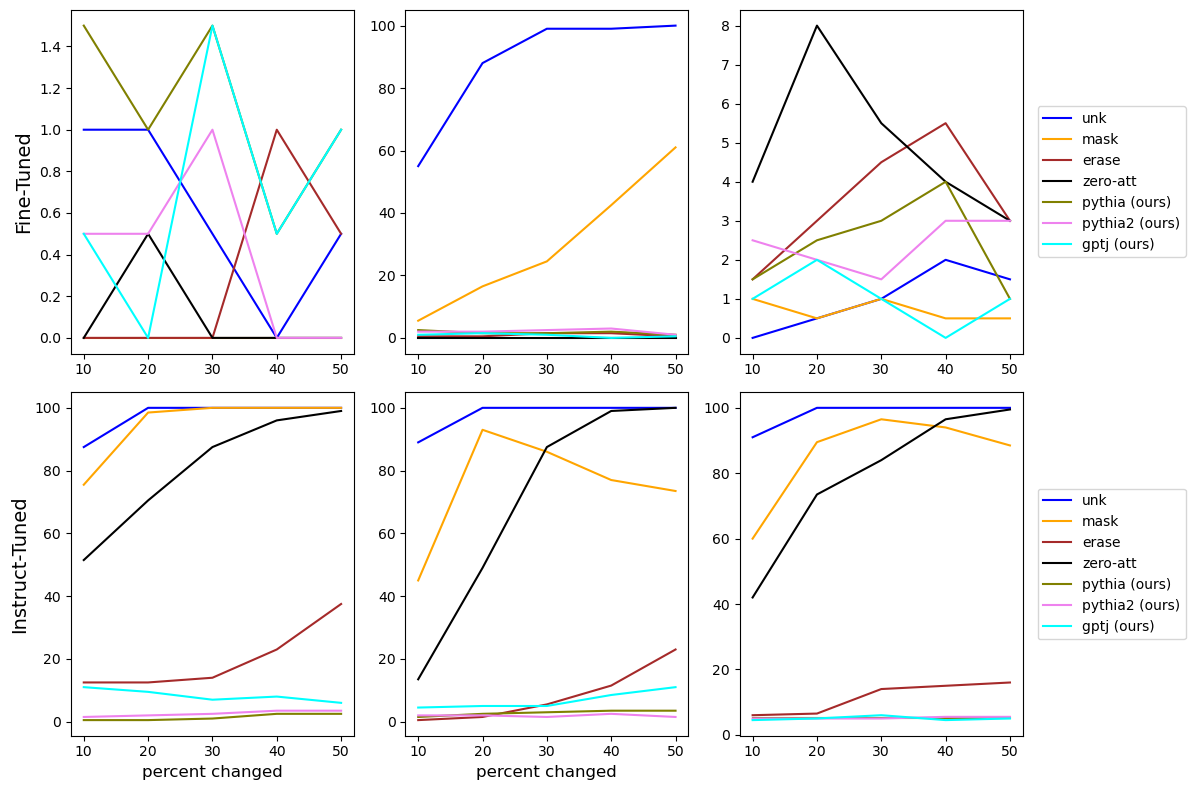

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


datasets = ["sst2","imdb","news"]
xticklabels = [10,20,30,40,50]
fig, ax = plt.subplots(2, 3, figsize=(12, 8))



for ds in datasets:
    for ft in [True,False]:
        if ds == "sst2":
            j = 0
        elif ds == "imdb":
            j = 1
        elif ds == "news":
            j=2
        if ft:
            i =0
            
        else:
            i=1
        ax[i,j].plot(xticklabels,oods_dict_cfg[f'{ds}-unk-gradnorm1-{ft}'],label = "unk",color = "blue")
        ax[i,j].plot(xticklabels,oods_dict_cfg[f'{ds}-mask-gradnorm1-{ft}'],label = "mask",color = "orange")

        ax[i,j].plot(xticklabels,oods_dict_cfg[f'{ds}-erase-gradnorm1-{ft}'],label = "erase",color = "brown")

        ax[i,j].plot(xticklabels,oods_dict_zero_att[f'{ds}-{ft}-gradnorm1'],label = "zero-att",color = "black")

        ax[i,j].plot(xticklabels,oods_dict_cfg[f'{ds}-pythia-gradnorm1-{ft}'],label = "pythia (ours)", color = "olive")

        ax[i,j].plot(xticklabels,oods_dict_cfg[f'{ds}-pythia2-gradnorm1-{ft}'],label = "pythia2 (ours)",color = "violet")

        ax[i,j].plot(xticklabels,oods_dict_cfg[f'{ds}-gptj-gradnorm1-{ft}'],label = "gptj (ours)",color = "cyan")
        
        if j ==2:
            ax[i,j].legend(bbox_to_anchor=(1.6, 0.5),loc='right')



ax[1,0].set_xlabel("percent changed",fontsize =12)
ax[1,1].set_xlabel("percent changed",fontsize =12)

ax[0,0].set_ylabel("Fine-Tuned",fontsize =14)
ax[1,0].set_ylabel("Instruct-Tuned",fontsize =14)

fig.tight_layout()
fig.savefig("ood_percent_changes.pdf", bbox_inches='tight')


In [182]:
for key in oods_dict_cfg.keys():
    if key[:4] == "imdb":
        print(key)
        arr = np.array(oods_dict_cfg[key])
        print(arr.mean())

imdb-pythia-gradnorm1-True
1.7
imdb-pythia-gradnorm2-True
1.4
imdb-pythia-gradinp-True
1.1
imdb-pythia-erasure-True
1.7
imdb-pythia-integrated_grad-True
2.3
imdb-pythia-kernel_shap-True
2.6
imdb-pythia-random-True
2.1
imdb-pythia-gradnorm1-False
2.8
imdb-pythia-gradnorm2-False
2.8
imdb-pythia-gradinp-False
4.4
imdb-pythia-erasure-False
2.4
imdb-pythia-integrated_grad-False
2.3
imdb-pythia-kernel_shap-False
3.8
imdb-pythia-random-False
4.3
imdb-pythia2-gradnorm1-True
2.1
imdb-pythia2-gradnorm2-True
2.9
imdb-pythia2-gradinp-True
1.7
imdb-pythia2-erasure-True
3.1
imdb-pythia2-integrated_grad-True
2.5
imdb-pythia2-kernel_shap-True
3.0
imdb-pythia2-random-True
2.3
imdb-pythia2-gradnorm1-False
1.9
imdb-pythia2-gradnorm2-False
1.9
imdb-pythia2-gradinp-False
3.0
imdb-pythia2-erasure-False
2.4
imdb-pythia2-integrated_grad-False
3.5
imdb-pythia2-kernel_shap-False
4.7
imdb-pythia2-random-False
3.9
imdb-gptj-gradnorm1-True
0.8
imdb-gptj-gradnorm2-True
1.4
imdb-gptj-gradinp-True
1.2
imdb-gptj-erasu

In [181]:
for key in oods_dict_zero_att.keys():
    if key[:4] == "imdb":
        print(key)
        arr = np.array(oods_dict_zero_att[key])
        print(arr.mean())

sst2-True-gradnorm1
0.1
sst2-True-gradnorm2
0.1
sst2-True-gradinp
0.0
sst2-True-erasure
0.1
sst2-True-integrated_grad
0.0
sst2-True-kernel_shap
0.0
sst2-True-random
0.0
sst2-False-gradnorm1
80.9
sst2-False-gradnorm2
80.8
sst2-False-gradinp
70.6
sst2-False-erasure
62.6
sst2-False-integrated_grad
65.8
sst2-False-kernel_shap
74.1
sst2-False-random
72.9
